In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Setting up imports and helper functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create directories for saving weights
base_path = "/content/drive/MyDrive/ATML_PA3/weights_1"
# os.makedirs(f"{base_path}/part_1", exist_ok=True)
# os.makedirs(f"{base_path}/part_2", exist_ok=True)
# os.makedirs(f"{base_path}/part_3", exist_ok=True)
# os.makedirs(f"{base_path}/part_4", exist_ok=True)
# os.makedirs(f"{base_path}/part_5", exist_ok=True)
# os.makedirs(f"{base_path}/part_6", exist_ok=True)
print("Created directories for saving model weights")

Using device: cuda
Created directories for saving model weights


In [ ]:
def get_cifar100_dataloaders(batch_size=128):
    """
    Get CIFAR-100 dataloaders with standard transforms
    """
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

# Initialize dataloaders
batch_size = 128
trainloader, testloader = get_cifar100_dataloaders(batch_size)
print("CIFAR-100 dataloaders created successfully!")

100%|██████████| 169M/169M [00:14<00:00, 11.5MB/s]


CIFAR-100 dataloaders created successfully!


In [5]:
# Cell 3: Model Definitions and Checkpoint Management

class VGG11(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 8x8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 4x4

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 2x2

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 1x1
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # Register hooks for intermediate features
        self.intermediate_features = {}

        # Register hooks on specific layers
        self._register_hooks()

    def _register_hooks(self):
        def make_hook(name):
            def hook(module, input, output):
                self.intermediate_features[name] = output
            return hook

        # Register hooks on selected layers (after each maxpool)
        # Layer indices: 3, 7, 14, 21, 28 (0-indexed)
        hook_layers = {
            3: 'pool1',   # After first maxpool
            7: 'pool2',   # After second maxpool
            14: 'pool3',  # After third maxpool
            21: 'pool4',  # After fourth maxpool
            28: 'pool5'   # After fifth maxpool
        }

        for idx, name in hook_layers.items():
            if idx < len(self.features):
                self.features[idx].register_forward_hook(make_hook(name))

    def forward(self, x):
        # Clear previous features
        self.intermediate_features = {}

        # Forward through features
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_features(self, layer_name):
        return self.intermediate_features.get(layer_name, None)


def get_vgg16_teacher(num_classes=100):
    """
    Get pretrained VGG-16 teacher model from torch hub
    """
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)

    # Freeze all teacher parameters
    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    print("Teacher model loaded and frozen successfully!")
    return model


# Checkpoint management functions (same as before)
def get_checkpoint_epoch(model_name, save_path):
    max_epoch = -1
    for filename in os.listdir(save_path):
        if filename.startswith(model_name) and filename.endswith('.pth'):
            try:
                epoch_num = int(filename.split('_')[-1].split('.')[0])
                max_epoch = max(max_epoch, epoch_num)
            except:
                continue
    return max_epoch

def save_checkpoint(model, optimizer, scheduler, epoch, best_acc, train_accuracies, test_accuracies,
                   model_name, save_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'best_acc': best_acc,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

    # Remove previous checkpoint for the same tenth epoch
    prev_epoch = epoch - 10
    if prev_epoch >= 0:
        prev_checkpoint_path = f"{save_path}/{model_name}_epoch_{prev_epoch:03d}.pth"
        if os.path.exists(prev_checkpoint_path):
            os.remove(prev_checkpoint_path)

    # Save new checkpoint
    checkpoint_path = f"{save_path}/{model_name}_epoch_{epoch:03d}.pth"
    torch.save(checkpoint, checkpoint_path)

    # Also save best model separately
    if epoch == best_acc:
        best_model_path = f"{save_path}/{model_name}_best.pth"
        torch.save(model.state_dict(), best_model_path)

    return checkpoint_path

def load_checkpoint(model, optimizer, scheduler, model_name, save_path):
    latest_epoch = get_checkpoint_epoch(model_name, save_path)
    if latest_epoch == -1:
        return model, optimizer, scheduler, 0, 0, [], [], False

    checkpoint_path = f"{save_path}/{model_name}_epoch_{latest_epoch:03d}.pth"
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print(f"Loaded checkpoint from epoch {latest_epoch}")
    return (model, optimizer, scheduler, checkpoint['epoch'], checkpoint['best_acc'],
            checkpoint['train_accuracies'], checkpoint['test_accuracies'], True)


# Initialize models
teacher_model = get_vgg16_teacher().to(device)
student_model = VGG11().to(device)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


100%|██████████| 58.4M/58.4M [00:01<00:00, 45.5MB/s]


Teacher model loaded and frozen successfully!


In [6]:
def count_feature_params(model):
    """Count parameters in feature extraction layers only"""
    feature_params = 0
    if hasattr(model, 'features'):
        # For VGG models
        for param in model.features.parameters():
            feature_params += param.numel()
    else:
        # For other architectures, you might need to adapt this
        # This counts all parameters except the last classifier layer
        for name, param in model.named_parameters():
            if 'classifier' not in name and 'fc' not in name:
                feature_params += param.numel()
    return feature_params

print(f"Teacher model (VGG-16) feature extractor parameters: {count_feature_params(teacher_model)}")
print(f"Student model (VGG-11) feature extractor parameters: {count_feature_params(student_model)}")

Teacher model (VGG-16) feature extractor parameters: 14723136
Student model (VGG-11) feature extractor parameters: 9225984


In [7]:
# Cell 4: Training Utilities with Checkpoint Management
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """
    Evaluate model on test set
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    return accuracy

def train_independent_student(student_model, trainloader, testloader, save_path, total_epochs=100):
    """
    Train independent student model from scratch with checkpointing
    """
    model_name = "independent_student"

    # Check if training is already complete
    latest_epoch = get_checkpoint_epoch(model_name, save_path)
    if latest_epoch >= total_epochs:
        print(f"Training already completed for {model_name} (epoch {latest_epoch})")
        # Load the final model
        final_checkpoint_path = f"{save_path}/{model_name}_epoch_{total_epochs:03d}.pth"
        checkpoint = torch.load(final_checkpoint_path)
        student_model.load_state_dict(checkpoint['model_state_dict'])
        return (checkpoint['train_accuracies'], checkpoint['test_accuracies'],
                checkpoint['best_acc'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80], gamma=0.1)

    # Load checkpoint if exists
    start_epoch = 0
    best_acc = 0
    train_accuracies = []
    test_accuracies = []

    student_model, optimizer, scheduler, start_epoch, best_acc, train_accuracies, test_accuracies, loaded = load_checkpoint(
        student_model, optimizer, scheduler, model_name, save_path)

    if loaded:
        print(f"Resuming training from epoch {start_epoch}")
        start_epoch += 1  # Start from next epoch

    if start_epoch >= total_epochs:
        print(f"Training already completed (epoch {start_epoch})")
        return train_accuracies, test_accuracies, best_acc

    print(f"Training Independent Student from epoch {start_epoch} to {total_epochs}...")
    for epoch in range(start_epoch, total_epochs):
        train_loss, train_acc = train_epoch(student_model, trainloader, criterion, optimizer, device)
        test_acc = evaluate(student_model, testloader, device)
        scheduler.step()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        # Save checkpoint every 10 epochs or at final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            checkpoint_path = save_checkpoint(
                student_model, optimizer, scheduler, epoch + 1, best_acc,
                train_accuracies, test_accuracies, model_name, save_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        if (epoch + 1) % 20 == 0:
            print(f'Epoch: {epoch+1:3d} | Train Loss: {train_loss:.3f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

    print(f'Best Test Accuracy: {best_acc:.2f}%')
    return train_accuracies, test_accuracies, best_acc

# Part 1: Logit Matching

In [8]:
# Cell 5: Knowledge Distillation Loss Functions for Part 1
class LogitMatchingLoss(nn.Module):
    """
    Basic Logit Matching (LM) loss
    """
    def __init__(self, alpha=0.7, temperature=4):
        super(LogitMatchingLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, targets):
        # Soften the logits using temperature
        soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)
        soft_student = F.log_softmax(student_logits / self.temperature, dim=1)

        # KL divergence between teacher and student
        kd_loss = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)

        # Cross entropy with true labels
        ce_loss = self.ce_loss(student_logits, targets)

        # Combined loss
        total_loss = self.alpha * kd_loss + (1. - self.alpha) * ce_loss
        return total_loss

class LabelSmoothingLoss(nn.Module):
    """
    Label Smoothing Regularization
    """
    def __init__(self, smoothing=0.1, temperature=4):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.temperature = temperature
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, targets):
        num_classes = student_logits.size(-1)

        # Create smoothed labels
        with torch.no_grad():
            true_dist = torch.zeros_like(student_logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)

        # Soften teacher logits
        soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)
        soft_student = F.log_softmax(student_logits / self.temperature, dim=1)

        # Combine losses
        kd_loss = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)
        ls_loss = self.kl_loss(F.log_softmax(student_logits, dim=1), true_dist)

        total_loss = 0.7 * kd_loss + 0.3 * ls_loss
        return total_loss

class DKDLoss(nn.Module):
    """
    Decoupled Knowledge Distillation Loss
    """
    def __init__(self, alpha=1.0, beta=2.0, temperature=4):
        super(DKDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, targets):
        # Target class and non-target class separation
        with torch.no_grad():
            teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
            student_probs = F.softmax(student_logits / self.temperature, dim=1)

            # Get target class indices
            batch_size, num_classes = teacher_logits.shape
            target_mask = torch.zeros_like(teacher_logits).scatter_(1, targets.unsqueeze(1), 1)

            # Target class probabilities
            target_teacher = (teacher_probs * target_mask).sum(dim=1)
            target_student = (student_probs * target_mask).sum(dim=1)

            # Non-target class probabilities (normalized)
            non_target_mask = 1 - target_mask
            non_target_teacher = teacher_probs * non_target_mask
            non_target_student = student_probs * non_target_mask

            non_target_teacher = non_target_teacher / non_target_teacher.sum(dim=1, keepdim=True)
            non_target_student = non_target_student / non_target_student.sum(dim=1, keepdim=True)

        # Target class loss
        target_loss = F.mse_loss(target_student, target_teacher)

        # Non-target class loss
        non_target_loss = F.kl_div(
            F.log_softmax(student_logits / self.temperature * non_target_mask, dim=1),
            F.softmax(teacher_logits / self.temperature * non_target_mask, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)

        # Cross entropy loss
        ce_loss = self.ce_loss(student_logits, targets)

        total_loss = ce_loss + self.alpha * target_loss + self.beta * non_target_loss
        return total_loss


# Enhanced Knowledge Distillation Loss Functions
class AdaptiveFeatureRegressor(nn.Module):
    """
    Adaptive regressor to align student features with teacher features
    """
    def __init__(self, student_channels, teacher_channels, student_spatial_size, teacher_spatial_size):
        super(AdaptiveFeatureRegressor, self).__init__()
        self.student_channels = student_channels
        self.teacher_channels = teacher_channels

        # Channel alignment
        self.channel_align = nn.Conv2d(student_channels, teacher_channels, kernel_size=1)

        # Spatial alignment (if needed)
        if student_spatial_size != teacher_spatial_size:
            self.spatial_align = nn.AdaptiveAvgPool2d(teacher_spatial_size)
        else:
            self.spatial_align = nn.Identity()

        self.bn = nn.BatchNorm2d(teacher_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.channel_align(x)
        x = self.spatial_align(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class HintLoss(nn.Module):
    """
    Hints-based Distillation Loss with adaptive feature regressor
    """
    def __init__(self, alpha=0.7):
        super(HintLoss, self).__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()
        # Regressor will be created dynamically based on feature shapes
        self.regressor = None

    def create_regressor(self, student_features, teacher_features):
        """Dynamically create regressor based on feature shapes"""
        student_channels = student_features.size(1)
        teacher_channels = teacher_features.size(1)
        student_spatial = student_features.size()[2:]
        teacher_spatial = teacher_features.size()[2:]

        self.regressor = AdaptiveFeatureRegressor(
            student_channels, teacher_channels, student_spatial, teacher_spatial
        ).to(student_features.device)

        print(f"Created regressor: {student_channels}->{teacher_channels} channels, "
              f"{student_spatial}->{teacher_spatial} spatial")

    def forward(self, student_logits, teacher_logits, targets, student_features, teacher_features):
        # Create regressor if not exists or if feature shapes changed
        if self.regressor is None or \
           self.regressor.student_channels != student_features.size(1) or \
           self.regressor.teacher_channels != teacher_features.size(1):
            self.create_regressor(student_features, teacher_features)

        # Align student features with teacher features
        aligned_student_features = self.regressor(student_features)

        # Hint loss: match intermediate features
        hint_loss = self.mse_loss(aligned_student_features, teacher_features)

        # Cross entropy with true labels
        ce_loss = self.ce_loss(student_logits, targets)

        # Combined loss
        total_loss = self.alpha * hint_loss + (1. - self.alpha) * ce_loss
        return total_loss

class CRDLoss(nn.Module):
    """
    Contrastive Representation Distillation Loss with adaptive feature regressor
    """
    def __init__(self, alpha=0.7, temperature=0.1, projection_dim=128):
        super(CRDLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        self.projection_dim = projection_dim

        # Regressor will be created dynamically
        self.regressor = None

        # Projection heads (input dim will be set dynamically)
        self.student_proj = None
        self.teacher_proj = None

    def create_regressor_and_projectors(self, student_features, teacher_features):
        """Dynamically create regressor and projectors based on feature shapes"""
        student_channels = student_features.size(1)
        teacher_channels = teacher_features.size(1)
        student_spatial = student_features.size()[2:]
        teacher_spatial = teacher_features.size()[2:]

        # Create regressor
        self.regressor = AdaptiveFeatureRegressor(
            student_channels, teacher_channels, student_spatial, teacher_spatial
        ).to(student_features.device)

        # Create projection heads
        self.student_proj = nn.Sequential(
            nn.Linear(teacher_channels, 256),  # Use teacher_channels after regressor
            nn.ReLU(),
            nn.Linear(256, self.projection_dim)
        ).to(student_features.device)

        self.teacher_proj = nn.Sequential(
            nn.Linear(teacher_channels, 256),
            nn.ReLU(),
            nn.Linear(256, self.projection_dim)
        ).to(student_features.device)

        print(f"Created CRD regressor: {student_channels}->{teacher_channels} channels")

    def contrastive_loss(self, student_features, teacher_features):
        batch_size = student_features.size(0)

        # Normalize features
        student_features = F.normalize(student_features, dim=1)
        teacher_features = F.normalize(teacher_features, dim=1)

        # Compute similarity matrix
        similarity = torch.matmul(student_features, teacher_features.t()) / self.temperature

        # Positive pairs are diagonal elements
        labels = torch.arange(batch_size).to(student_features.device)

        loss = F.cross_entropy(similarity, labels)
        return loss

    def forward(self, student_logits, teacher_logits, targets, student_features, teacher_features):
        # Create regressor and projectors if not exists
        if self.regressor is None or self.student_proj is None or self.teacher_proj is None:
            self.create_regressor_and_projectors(student_features, teacher_features)

        # Align student features with teacher features
        aligned_student_features = self.regressor(student_features)

        # Global average pooling
        student_pooled = F.adaptive_avg_pool2d(aligned_student_features, (1, 1))
        student_pooled = student_pooled.view(student_pooled.size(0), -1)

        teacher_pooled = F.adaptive_avg_pool2d(teacher_features, (1, 1))
        teacher_pooled = teacher_pooled.view(teacher_pooled.size(0), -1)

        # Project features
        student_proj = self.student_proj(student_pooled)
        teacher_proj = self.teacher_proj(teacher_pooled)

        # Contrastive loss
        crd_loss = self.contrastive_loss(student_proj, teacher_proj)

        # Cross entropy with true labels
        ce_loss = self.ce_loss(student_logits, targets)

        # Combined loss
        total_loss = self.alpha * crd_loss + (1. - self.alpha) * ce_loss
        return total_loss

In [9]:
# Cell 5: Enhanced Training Function with Robust Feature Extraction
def get_teacher_features(teacher_model, x):
    """
    Extract features from teacher model - try multiple approaches
    """
    features = None

    def hook(module, input, output):
        nonlocal features
        features = output

    # Try different approaches to get teacher features
    try:
        # Approach 1: Try to get features from named modules
        if hasattr(teacher_model, 'features'):
            # VGG-style model
            target_layer = teacher_model.features[-2]  # Last conv layer before final pooling
            handle = target_layer.register_forward_hook(hook)
            with torch.no_grad():
                _ = teacher_model(x)
            handle.remove()
        else:
            # Approach 2: Try to find a conv layer
            for name, module in teacher_model.named_modules():
                if isinstance(module, nn.Conv2d):
                    target_layer = module
                    break
            handle = target_layer.register_forward_hook(hook)
            with torch.no_grad():
                _ = teacher_model(x)
            handle.remove()
    except Exception as e:
        print(f"Error extracting teacher features: {e}")
        # Fallback: use the output of the feature extractor
        if hasattr(teacher_model, 'features'):
            with torch.no_grad():
                features = teacher_model.features(x)
        else:
            # Last resort: use a portion of the model
            with torch.no_grad():
                features = teacher_model(x)
                # If we get logits, we can't use them for feature matching
                if features.dim() == 2 and features.size(1) == 100:  # Assuming 100 classes
                    features = None

    return features

def train_with_distillation(student_model, teacher_model, trainloader, testloader,
                          loss_fn, method_name, save_path, total_epochs=100):
    """
    Train student model using knowledge distillation with checkpointing
    """
    model_name = method_name.lower().replace(' ', '_')

    # Check if training is already complete
    latest_epoch = get_checkpoint_epoch(model_name, save_path)
    if latest_epoch >= total_epochs:
        print(f"Training already completed for {model_name} (epoch {latest_epoch})")
        # Load the final model
        final_checkpoint_path = f"{save_path}/{model_name}_epoch_{total_epochs:03d}.pth"
        checkpoint = torch.load(final_checkpoint_path)
        student_model.load_state_dict(checkpoint['model_state_dict'])
        return (checkpoint['train_accuracies'], checkpoint['test_accuracies'],
                checkpoint['best_acc'])

    # Create optimizer - include regressor parameters if they exist
    params_to_optimize = list(student_model.parameters())
    if method_name in ['hints', 'crd']:
        # Add regressor parameters to optimizer
        if hasattr(loss_fn, 'regressor') and loss_fn.regressor is not None:
            params_to_optimize += list(loss_fn.regressor.parameters())
        if hasattr(loss_fn, 'student_proj') and loss_fn.student_proj is not None:
            params_to_optimize += list(loss_fn.student_proj.parameters())
        if hasattr(loss_fn, 'teacher_proj') and loss_fn.teacher_proj is not None:
            params_to_optimize += list(loss_fn.teacher_proj.parameters())

    optimizer = optim.SGD(params_to_optimize, lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80], gamma=0.1)

    teacher_model.eval()  # Teacher in eval mode

    # Load checkpoint if exists
    start_epoch = 0
    best_acc = 0
    train_accuracies = []
    test_accuracies = []

    student_model, optimizer, scheduler, start_epoch, best_acc, train_accuracies, test_accuracies, loaded = load_checkpoint(
        student_model, optimizer, scheduler, model_name, save_path)

    if loaded:
        print(f"Resuming training from epoch {start_epoch}")
        start_epoch += 1  # Start from next epoch

    if start_epoch >= total_epochs:
        print(f"Training already completed (epoch {start_epoch})")
        return train_accuracies, test_accuracies, best_acc

    print(f"Training with {method_name} from epoch {start_epoch} to {total_epochs}...")
    for epoch in range(start_epoch, total_epochs):
        student_model.train()
        # Set regressor and projectors to train mode
        if method_name in ['hints', 'crd']:
            if hasattr(loss_fn, 'regressor') and loss_fn.regressor is not None:
                loss_fn.regressor.train()
            if hasattr(loss_fn, 'student_proj') and loss_fn.student_proj is not None:
                loss_fn.student_proj.train()
            if hasattr(loss_fn, 'teacher_proj') and loss_fn.teacher_proj is not None:
                loss_fn.teacher_proj.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)
                # Extract teacher features for hints and CRD
                if method_name in ['hints', 'crd']:
                    teacher_features = get_teacher_features(teacher_model, inputs)
                else:
                    teacher_features = None

            student_logits = student_model(inputs)

            # Extract student features for hints and CRD
            if method_name in ['hints', 'crd']:
                # Try different layers to find features
                student_features = None
                for layer_name in ['pool3', 'pool4', 'pool2']:  # Try in order of preference
                    student_features = student_model.get_features(layer_name)
                    if student_features is not None:
                        break
            else:
                student_features = None

            # Calculate loss based on method
            if method_name == 'logit_matching':
                loss = loss_fn(student_logits, teacher_logits, targets)
            elif method_name in ['hints', 'crd'] and student_features is not None and teacher_features is not None:
                # Print feature shapes for debugging (first batch only)
                if epoch == start_epoch and batch_idx == 0:
                    print(f"Student features shape: {student_features.shape}")
                    print(f"Teacher features shape: {teacher_features.shape}")

                loss = loss_fn(student_logits, teacher_logits, targets, student_features, teacher_features)
            else:
                # Fallback to CE loss if feature extraction fails
                loss = F.cross_entropy(student_logits, targets)
                if method_name in ['hints', 'crd'] and batch_idx == 0:
                    print("Warning: Feature extraction failed, using CE loss")

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = student_logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        test_acc = evaluate(student_model, testloader, device)
        scheduler.step()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        # Save checkpoint every 10 epochs or at final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            checkpoint_path = save_checkpoint(
                student_model, optimizer, scheduler, epoch + 1, best_acc,
                train_accuracies, test_accuracies, model_name, save_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:3d} | Train Loss: {running_loss/len(trainloader):.3f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

    print(f'Best Test Accuracy: {best_acc:.2f}%')
    return train_accuracies, test_accuracies, best_acc


In [ ]:
# Part 1: Train with different distillation methods
print("=== PART 1: LOGIT MATCHING METHODS ===")
save_path_part1 = f"{base_path}/part_1"

# Initialize fresh student models for each method
student_lm = VGG11().to(device)
student_ls = VGG11().to(device)
student_dkd = VGG11().to(device)

print("\n=== Logit Matching (LM) ===")
lm_loss = LogitMatchingLoss(alpha=0.7, temperature=4)
train_acc_lm, test_acc_lm, best_lm = train_with_distillation(
    student_lm, teacher_model, trainloader, testloader, lm_loss, "logit_matching",
    save_path_part1, total_epochs=50)

print("\n=== Label Smoothing ===")
ls_loss = LabelSmoothingLoss(smoothing=0.1, temperature=4)
train_acc_ls, test_acc_ls, best_ls = train_with_distillation(
    student_ls, teacher_model, trainloader, testloader, ls_loss, "label_smoothing",
    save_path_part1, total_epochs=50)

print("\n=== Decoupled KD (DKD) ===")
dkd_loss = DKDLoss(alpha=1.0, beta=2.0, temperature=4)
train_acc_dkd, test_acc_dkd, best_dkd = train_with_distillation(
    student_dkd, teacher_model, trainloader, testloader, dkd_loss, "decoupled_kd",
    save_path_part1, total_epochs=50)

print("\nPart 1 completed! Models saved.")

=== PART 1: LOGIT MATCHING METHODS ===

=== Logit Matching (LM) ===
Training with logit_matching from epoch 0 to 50...
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_1/logit_matching_epoch_010.pth
Epoch:  10 | Train Loss: 10.248 | Train Acc: 31.28% | Test Acc: 32.25%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_1/logit_matching_epoch_020.pth
Epoch:  20 | Train Loss: 8.680 | Train Acc: 43.03% | Test Acc: 36.55%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_1/logit_matching_epoch_030.pth
Epoch:  30 | Train Loss: 8.152 | Train Acc: 46.90% | Test Acc: 41.56%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_1/logit_matching_epoch_040.pth
Epoch:  40 | Train Loss: 7.829 | Train Acc: 49.62% | Test Acc: 43.93%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_1/logit_matching_epoch_050.pth
Epoch:  50 | Train Loss: 7.666 | Train Acc: 50.75% | Test Acc: 46.39%
Best Test Accuracy: 47.99%

=== Label Smoothing ==

# Part 2: Comparing Performance of SoTA Approaches

In [10]:
def load_model_from_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [ ]:
# Cell 7: Independent Student Training

print("=== PART 2: COMPARING PERFORMANCE OF SOTA APPROACHES ===")
save_path_part2 = f"{base_path}/part_2"

# Train independent student for baseline
student_independent = VGG11().to(device)
train_acc_ind, test_acc_ind, best_ind = train_independent_student(
    student_independent, trainloader, testloader, save_path_part2, total_epochs=50)

=== PART 2: COMPARING PERFORMANCE OF SOTA APPROACHES ===
Training Independent Student from epoch 0 to 50...
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/independent_student_epoch_010.pth
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/independent_student_epoch_020.pth
Epoch:  20 | Train Loss: 2.007 | Train Acc: 46.82% | Test Acc: 44.86%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/independent_student_epoch_030.pth
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/independent_student_epoch_040.pth
Epoch:  40 | Train Loss: 1.785 | Train Acc: 53.05% | Test Acc: 46.85%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/independent_student_epoch_050.pth
Best Test Accuracy: 49.70%


In [ ]:
# Cell 8: Training Other KD Methods

print("=== PART 1: TRAINING ALL THREE KD METHODS ===")
save_path_part1 = f"{base_path}/part_1"

# Initialize fresh student models for each method
student_lm = VGG11().to(device)
student_lm = load_model_from_checkpoint(student_lm, f'{base_path}/part_1/logit_matching_epoch_050.pth')

student_hints = VGG11().to(device)
student_crd = VGG11().to(device)

save_path_part2 = f"{base_path}/part_2"

print("\n=== Hints-based Distillation ===")
hints_loss = HintLoss(alpha=0.7)

train_acc_hints, test_acc_hints, best_hints = train_with_distillation(
    student_hints, teacher_model, trainloader, testloader, hints_loss, "hints",
    save_path_part2, total_epochs=50)


print("\n=== Contrastive Representation Distillation (CRD) ===")
crd_loss = CRDLoss(alpha=0.7, temperature=0.1)

train_acc_crd, test_acc_crd, best_crd = train_with_distillation(
    student_crd, teacher_model, trainloader, testloader, crd_loss, "crd",
    save_path_part2, total_epochs=50)

print("\nPart 1 completed! All three KD methods trained and saved.")

=== PART 1: TRAINING ALL THREE KD METHODS ===

=== Hints-based Distillation ===
Training with hints from epoch 0 to 50...
Student features shape: torch.Size([128, 256, 4, 4])
Teacher features shape: torch.Size([128, 512, 2, 2])
Created regressor: 256->512 channels, torch.Size([4, 4])->torch.Size([2, 2]) spatial
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/hints_epoch_010.pth
Epoch:  10 | Train Loss: 0.890 | Train Acc: 32.13% | Test Acc: 29.60%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/hints_epoch_020.pth
Epoch:  20 | Train Loss: 0.788 | Train Acc: 40.66% | Test Acc: 33.49%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/hints_epoch_030.pth
Epoch:  30 | Train Loss: 0.748 | Train Acc: 44.42% | Test Acc: 37.16%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_2/hints_epoch_040.pth
Epoch:  40 | Train Loss: 0.724 | Train Acc: 46.58% | Test Acc: 41.30%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1

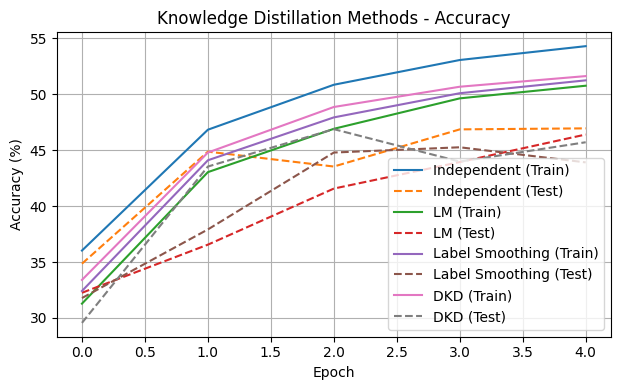


=== FINAL RESULTS COMPARISON ===
Teacher (VGG-16) Accuracy: 74.00%

=== ALL METHODS COMPARISON ===
Method          Best Accuracy   Improvement over Independent  
-----------------------------------------------------------------
Independent     46.94           -                             
LM              47.99           +1.05%
Label Smoothing 46.83           -0.11%
DKD             48.13           +1.19%

Part 2 completed! Results saved.


In [ ]:
# Collect results
methods_results = {
    'Independent': (train_acc_ind, test_acc_ind, best_ind),
    'LM': (train_acc_lm, test_acc_lm, best_lm),
    'Label Smoothing': (train_acc_ls, test_acc_ls, best_ls),
    'DKD': (train_acc_dkd, test_acc_dkd, best_dkd),
}

# Plot results
plot_training_curves(methods_results, "Knowledge Distillation Methods")

# Print final comparison
print("\n=== FINAL RESULTS COMPARISON ===")
teacher_acc = evaluate(teacher_model, testloader, device)
print(f"Teacher (VGG-16) Accuracy: {teacher_acc:.2f}%")

print("\n=== ALL METHODS COMPARISON ===")
print(f"{'Method':<15} {'Best Accuracy':<15} {'Improvement over Independent':<30}")
print("-" * 65)
for method, (_, _, best_acc) in methods_results.items():
    if method != 'Independent':
        improvement = best_acc - best_ind
        print(f"{method:<15} {best_acc:<15.2f} {improvement:+.2f}%")
    else:
        print(f"{method:<15} {best_acc:<15.2f} {'-':<30}")

# Save comparison results
import json
results_dict = {
    'teacher_accuracy': float(teacher_acc),
    'methods': {method: float(acc) for method, (_, _, acc) in methods_results.items()}
}
with open(f"{save_path_part2}/performance_results.json", 'w') as f:
    json.dump(results_dict, f, indent=2)

print("\nPart 2 completed! Results saved.")

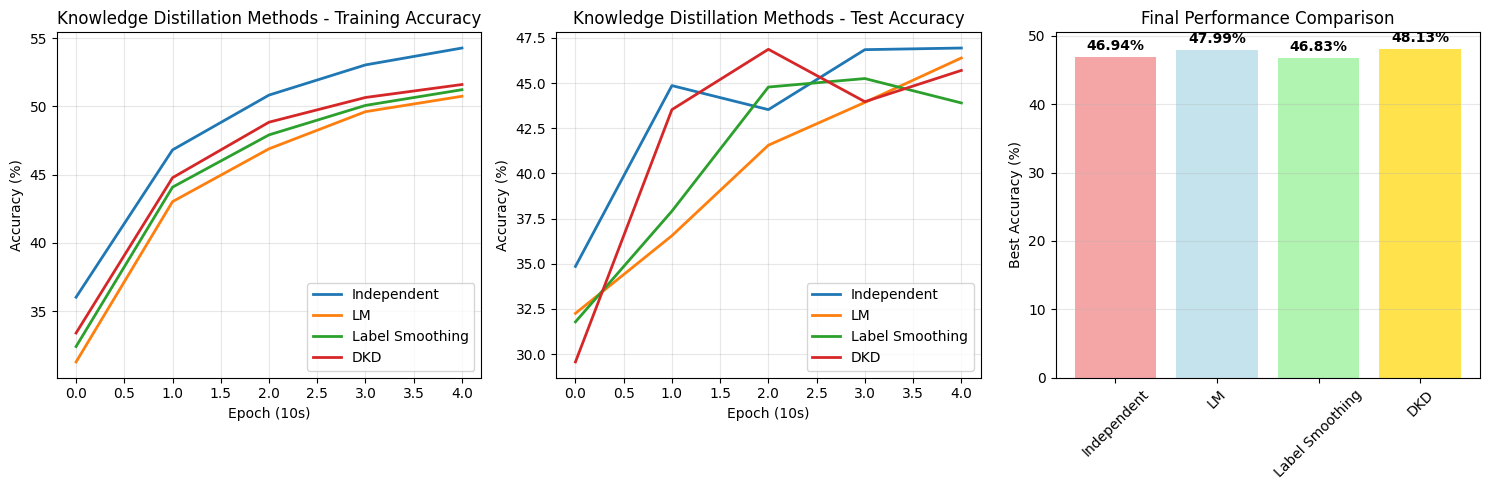


=== FINAL RESULTS COMPARISON ===
Teacher (VGG-16) Accuracy: 74.00%

=== ALL METHODS COMPARISON ===
Method               Best Accuracy   Improvement over Independent  
----------------------------------------------------------------------
Independent          46.94           -                             
LM                   47.99           +1.05% (+2.2%)
Label Smoothing      46.83           -0.11% (-0.2%)
DKD                  48.13           +1.19% (+2.5%)

=== RELATIVE PERFORMANCE ===
Method               Relative to Teacher  Efficiency Ratio
------------------------------------------------------------
LM                   26.01                1.54           
Label Smoothing      27.17                1.58           
DKD                  25.87                1.54           

Part 2 completed! Results saved.


In [ ]:
# Cell 7: Performance Comparison and Analysis for Part 2
def plot_training_curves_separate(methods_data, title="Training Progress"):
    """
    Plot training curves for different methods with separate train and test plots
    """
    plt.figure(figsize=(15, 5))

    # Plot 1: Training Accuracy
    plt.subplot(1, 3, 1)
    for method_name, (train_acc, test_acc, best_acc) in methods_data.items():
        plt.plot(train_acc, label=method_name, linewidth=2)
    plt.xlabel('Epoch (10s)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Test Accuracy
    plt.subplot(1, 3, 2)
    for method_name, (train_acc, test_acc, best_acc) in methods_data.items():
        plt.plot(test_acc, label=method_name, linewidth=2)
    plt.xlabel('Epoch (10s)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Final Comparison Bar Chart
    plt.subplot(1, 3, 3)
    methods = list(methods_data.keys())
    best_accuracies = [best_acc for _, _, best_acc in methods_data.values()]

    colors = ['lightcoral', 'lightblue', 'lightgreen', 'gold', 'violet']
    bars = plt.bar(methods, best_accuracies, color=colors[:len(methods)], alpha=0.7)

    # Add value labels on bars
    for bar, acc in zip(bars, best_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.ylabel('Best Accuracy (%)')
    plt.title('Final Performance Comparison')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Collect results
methods_results = {
    'Independent': (train_acc_ind, test_acc_ind, best_ind),
    'LM': (train_acc_lm, test_acc_lm, best_lm),
    'Label Smoothing': (train_acc_ls, test_acc_ls, best_ls),
    'DKD': (train_acc_dkd, test_acc_dkd, best_dkd),
}

# Plot results with separate train/test plots
plot_training_curves_separate(methods_results, "Knowledge Distillation Methods")

# Print final comparison
print("\n=== FINAL RESULTS COMPARISON ===")
teacher_acc = evaluate(teacher_model, testloader, device)
print(f"Teacher (VGG-16) Accuracy: {teacher_acc:.2f}%")

print("\n=== ALL METHODS COMPARISON ===")
print(f"{'Method':<20} {'Best Accuracy':<15} {'Improvement over Independent':<30}")
print("-" * 70)
for method, (_, _, best_acc) in methods_results.items():
    if method != 'Independent':
        improvement = best_acc - best_ind
        improvement_percent = (improvement / best_ind) * 100
        print(f"{method:<20} {best_acc:<15.2f} {improvement:+.2f}% ({improvement_percent:+.1f}%)")
    else:
        print(f"{method:<20} {best_acc:<15.2f} {'-':<30}")

# Calculate relative improvements
print(f"\n=== RELATIVE PERFORMANCE ===")
print(f"{'Method':<20} {'Relative to Teacher':<20} {'Efficiency Ratio':<15}")
print("-" * 60)
for method, (_, _, best_acc) in methods_results.items():
    if method != 'Independent':
        teacher_gap = teacher_acc - best_acc
        efficiency = teacher_acc / best_acc if best_acc > 0 else float('inf')
        print(f"{method:<20} {teacher_gap:<20.2f} {efficiency:<15.2f}")

# Save comparison results
results_dict = {
    'teacher_accuracy': float(teacher_acc),
    'methods': {
        method: {
            'best_accuracy': float(acc),
            'train_accuracies': [float(x) for x in train_acc],
            'test_accuracies': [float(x) for x in test_acc],
            'improvement_over_independent': float(acc - best_ind) if method != 'Independent' else 0
        }
        for method, (train_acc, test_acc, acc) in methods_results.items()
    }
}
with open(f"{save_path_part2}/performance_results.json", 'w') as f:
    json.dump(results_dict, f, indent=2)

print("\nPart 2 completed! Results saved.")

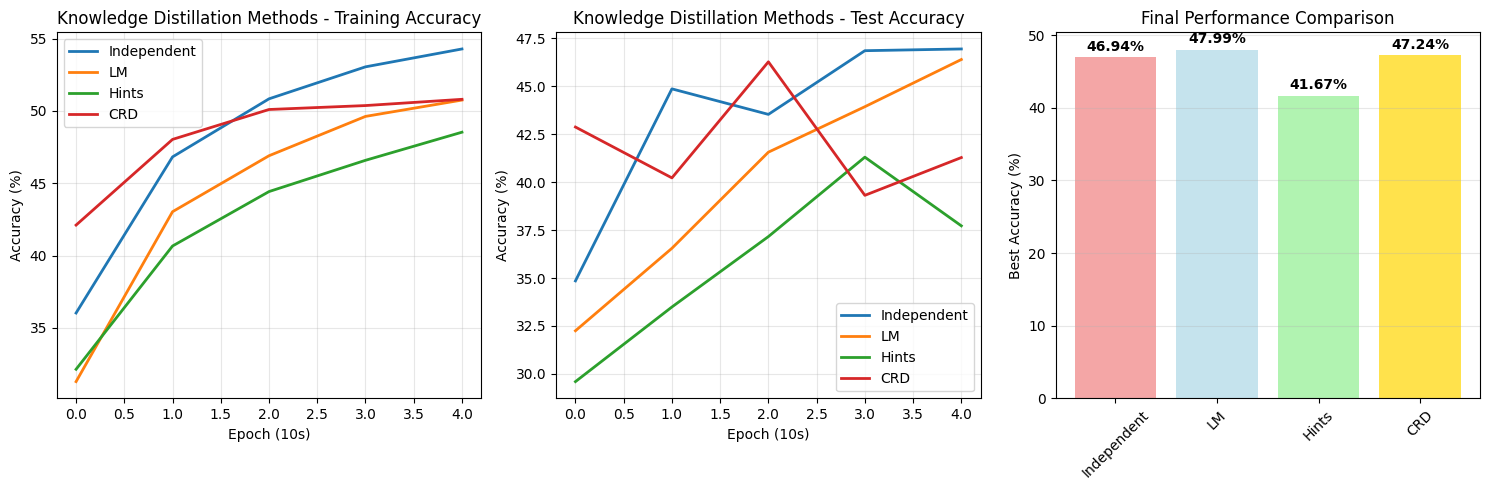


=== FINAL RESULTS COMPARISON ===
Teacher (VGG-16) Accuracy: 74.00%

=== ALL METHODS COMPARISON ===
Method               Best Accuracy   Improvement over Independent  
----------------------------------------------------------------------
Independent          46.94           -                             
LM                   47.99           +1.05% (+2.2%)
Hints                41.67           -5.27% (-11.2%)
CRD                  47.24           +0.30% (+0.6%)

=== RELATIVE PERFORMANCE ===
Method               Relative to Teacher  Efficiency Ratio
------------------------------------------------------------
LM                   26.01                1.54           
Hints                32.33                1.78           
CRD                  26.76                1.57           

Part 2 completed! Results saved.


In [ ]:
import json

# Cell 7: Performance Comparison and Analysis for IS, LM, Hints and CRD
def plot_training_curves_separate(methods_data, title="Training Progress"):
    """
    Plot training curves for different methods with separate train and test plots
    """
    plt.figure(figsize=(15, 5))

    # Plot 1: Training Accuracy
    plt.subplot(1, 3, 1)
    for method_name, (train_acc, test_acc, best_acc) in methods_data.items():
        plt.plot(train_acc, label=method_name, linewidth=2)
    plt.xlabel('Epoch (10s)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Test Accuracy
    plt.subplot(1, 3, 2)
    for method_name, (train_acc, test_acc, best_acc) in methods_data.items():
        plt.plot(test_acc, label=method_name, linewidth=2)
    plt.xlabel('Epoch (10s)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Final Comparison Bar Chart
    plt.subplot(1, 3, 3)
    methods = list(methods_data.keys())
    best_accuracies = [best_acc for _, _, best_acc in methods_data.values()]

    colors = ['lightcoral', 'lightblue', 'lightgreen', 'gold', 'violet']
    bars = plt.bar(methods, best_accuracies, color=colors[:len(methods)], alpha=0.7)

    # Add value labels on bars
    for bar, acc in zip(bars, best_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.ylabel('Best Accuracy (%)')
    plt.title('Final Performance Comparison')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Collect results
methods_results = {
    'Independent': (train_acc_ind, test_acc_ind, best_test_ind),
    'LM': (train_acc_lm, test_acc_lm, best_test_lm),
    'Hints': (train_acc_hints, test_acc_hints, best_test_hints),
    'CRD': (train_acc_crd, test_acc_crd, best_test_crd),
}

# Plot results with separate train/test plots
plot_training_curves_separate(methods_results, "Knowledge Distillation Methods")

# Print final comparison
print("\n=== FINAL RESULTS COMPARISON ===")
teacher_acc = evaluate(teacher_model, testloader, device)
print(f"Teacher (VGG-16) Accuracy: {teacher_acc:.2f}%")

print("\n=== ALL METHODS COMPARISON ===")
print(f"{'Method':<20} {'Best Accuracy':<15} {'Improvement over Independent':<30}")
print("-" * 70)
for method, (_, _, best_acc) in methods_results.items():
    if method != 'Independent':
        improvement = best_acc - best_ind
        improvement_percent = (improvement / best_ind) * 100
        print(f"{method:<20} {best_acc:<15.2f} {improvement:+.2f}% ({improvement_percent:+.1f}%)")
    else:
        print(f"{method:<20} {best_acc:<15.2f} {'-':<30}")

# Calculate relative improvements
print(f"\n=== RELATIVE PERFORMANCE ===")
print(f"{'Method':<20} {'Relative to Teacher':<20} {'Efficiency Ratio':<15}")
print("-" * 60)
for method, (_, _, best_acc) in methods_results.items():
    if method != 'Independent':
        teacher_gap = teacher_acc - best_acc
        efficiency = teacher_acc / best_acc if best_acc > 0 else float('inf')
        print(f"{method:<20} {teacher_gap:<20.2f} {efficiency:<15.2f}")

# Save comparison results
results_dict = {
    'teacher_accuracy': float(teacher_acc),
    'methods': {
        method: {
            'best_accuracy': float(acc),
            'train_accuracies': [float(x) for x in train_acc],
            'test_accuracies': [float(x) for x in test_acc],
            'improvement_over_independent': float(acc - best_ind) if method != 'Independent' else 0
        }
        for method, (train_acc, test_acc, acc) in methods_results.items()
    }
}
with open(f"{save_path_part2}/performance_results.json", 'w') as f:
    json.dump(results_dict, f, indent=2)

print("\nPart 2 completed! Results saved.")

# Part 3


=== PART 3: PROBABILITY DISTRIBUTION ANALYSIS ===
KL Divergence (lower is better):
Student Model        KL Divergence  
----------------------------------------
LM                   0.4149         
Label_Smoothing      0.4441         
DKD                  0.5307         
Independent          0.5117         


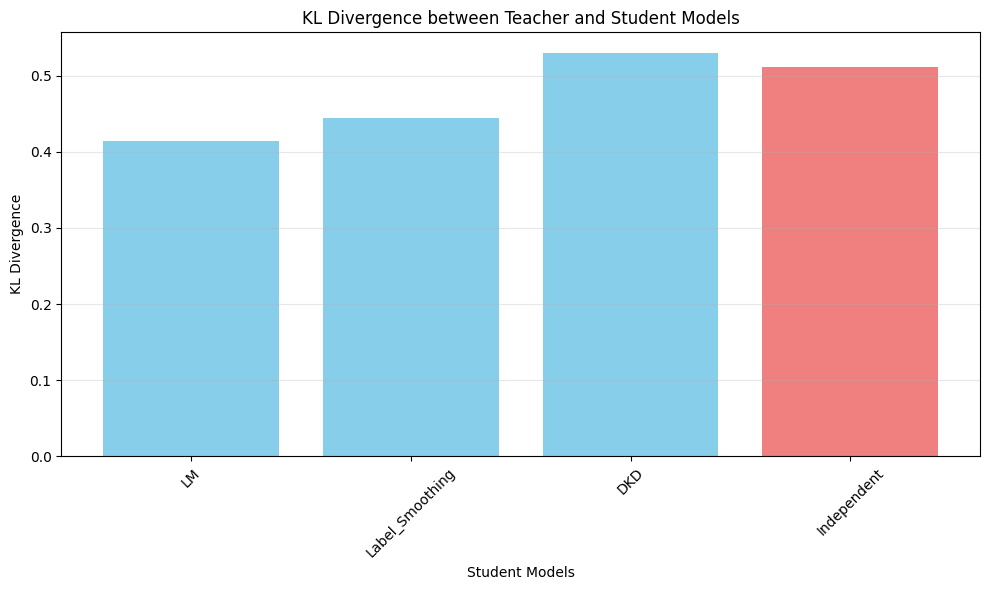


Part 3 completed! Distribution analysis saved.


In [ ]:
# Cell 8: Probability Distribution Analysis for Part 3
def calculate_kl_divergence(model1, model2, dataloader, device, temperature=4):
    """
    Calculate KL divergence between two models' probability distributions
    """
    model1.eval()
    model2.eval()

    total_kl = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # Get logits and convert to probabilities
            logits1 = model1(inputs)
            logits2 = model2(inputs)

            probs1 = F.softmax(logits1 / temperature, dim=1)
            probs2 = F.softmax(logits2 / temperature, dim=1)

            # Calculate KL divergence
            kl_div = F.kl_div(
                torch.log(probs2 + 1e-8),  # Add small epsilon to avoid log(0)
                probs1,
                reduction='batchmean'
            )

            total_kl += kl_div.item()
            num_batches += 1

    return total_kl / num_batches

def analyze_probability_distributions(teacher, students_dict, testloader, device, save_path):
    """
    Analyze probability distributions between teacher and students
    """
    print("\n=== PART 3: PROBABILITY DISTRIBUTION ANALYSIS ===")
    print("KL Divergence (lower is better):")
    print(f"{'Student Model':<20} {'KL Divergence':<15}")
    print("-" * 40)

    results = {}
    for student_name, student_model in students_dict.items():
        kl_div = calculate_kl_divergence(teacher, student_model, testloader, device)
        results[student_name] = kl_div
        print(f"{student_name:<20} {kl_div:<15.4f}")

    # Compare with independent student
    ind_kl = calculate_kl_divergence(teacher, student_independent, testloader, device)
    results['Independent'] = ind_kl
    print(f"{'Independent':<20} {ind_kl:<15.4f}")

    # Save results
    with open(f"{save_path}/kl_divergence_results.json", 'w') as f:
        json.dump(results, f, indent=2)

    # Plot results
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    kl_values = list(results.values())

    plt.bar(models, kl_values, color=['skyblue' if x != 'Independent' else 'lightcoral' for x in models])
    plt.xlabel('Student Models')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence between Teacher and Student Models')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results

# Load models from checkpoints (corrected)
student_lm = VGG11().to(device)
student_ls = VGG11().to(device)
student_dkd = VGG11().to(device)

student_lm = load_model_from_checkpoint(student_lm, f'{base_path}/part_1/logit_matching_epoch_050.pth')
student_ls = load_model_from_checkpoint(student_ls, f'{base_path}/part_1/label_smoothing_epoch_050.pth')
student_dkd = load_model_from_checkpoint(student_dkd, f'{base_path}/part_1/decoupled_kd_epoch_050.pth')

# Part 3: Analyze distributions
save_path_part3 = f"{base_path}/part_3"
students_dict = {
    'LM': student_lm,
    'Label_Smoothing': student_ls,
    'DKD': student_dkd,
}

kl_results = analyze_probability_distributions(teacher_model, students_dict, testloader, device, save_path_part3)
print("\nPart 3 completed! Distribution analysis saved.")

Loading trained models for probability distribution analysis...
All models loaded successfully!

PART 3: COMPARING PROBABILITY DISTRIBUTIONS

Justification of Metrics:
- KL Divergence: Measures how one probability distribution diverges from another
- JS Divergence: Symmetric version of KL, bounded between 0 and 1
- Cosine Similarity: Measures angular similarity between probability vectors
- L2 Distance: Euclidean distance between probability vectors

All metrics use temperature=4 for softened probabilities (same as training)

Model                KL Divergence   JS Divergence   Cosine Sim      L2 Distance    
-------------------------------------------------------------------------------------
Logit_Matching       0.4149          0.1113          0.6935          0.2130         
Hints_Based          0.5837          0.1515          0.5948          0.2526         
CRD                  0.5440          0.1406          0.6178          0.2477         
Independent          0.5095          0.132

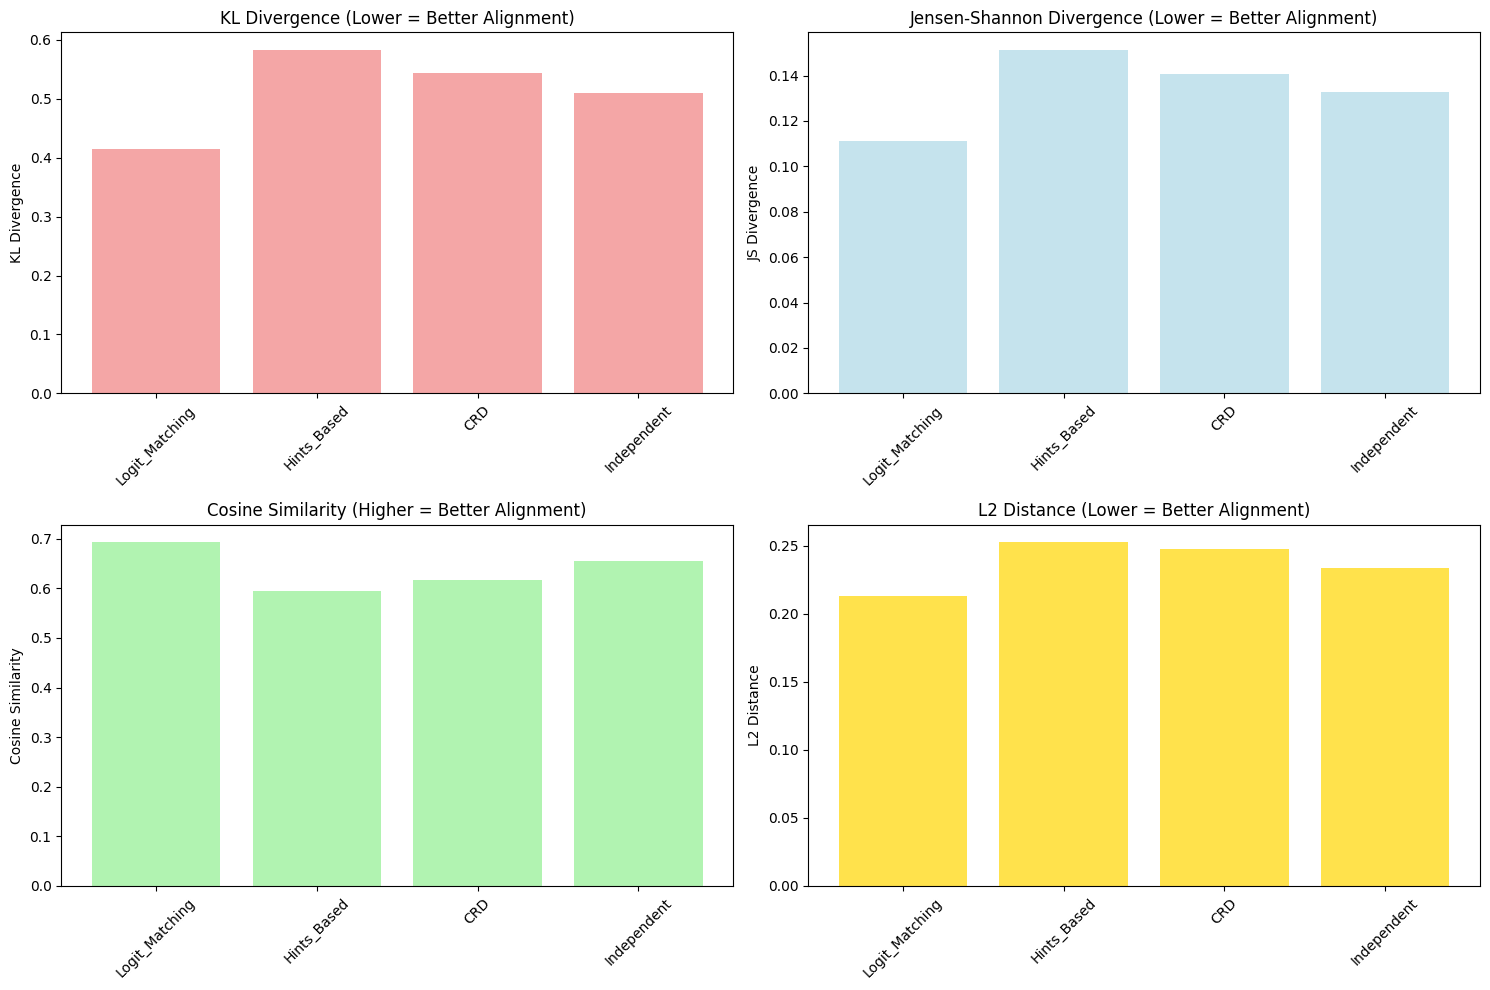

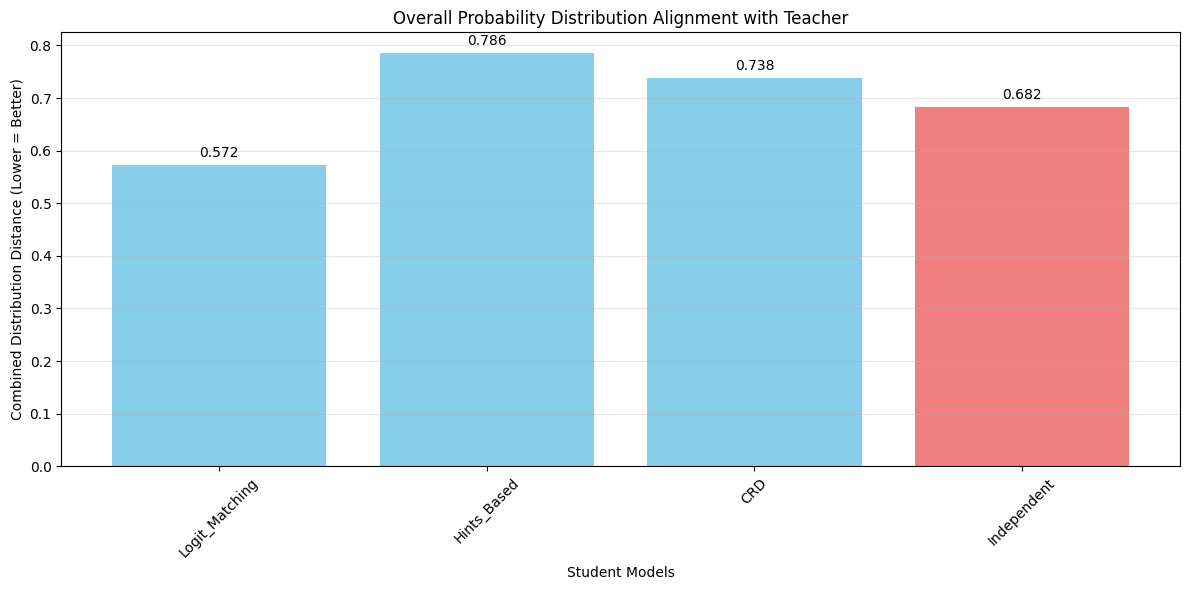


STATISTICAL ANALYSIS

Best Performing Methods by Metric:
--------------------------------------------------
kl_divergence        Logit_Matching       0.4149
js_divergence        Logit_Matching       0.1113
cosine_similarity    Logit_Matching       0.6935
l2_distance          Logit_Matching       0.2130

Improvement Over Independent Student:
--------------------------------------------------

Logit_Matching:
  kl_divergence        +0.0945 (+18.6%)
  js_divergence        +0.0216 (+16.2%)
  cosine_similarity    +0.0384 (+5.9%)
  l2_distance          +0.0204 (+8.8%)

Hints_Based:
  kl_divergence        -0.0742 (-14.6%)
  js_divergence        -0.0186 (-14.0%)
  cosine_similarity    -0.0603 (-9.2%)
  l2_distance          -0.0192 (-8.2%)

CRD:
  kl_divergence        -0.0346 (-6.8%)
  js_divergence        -0.0077 (-5.8%)
  cosine_similarity    -0.0372 (-5.7%)
  l2_distance          -0.0143 (-6.1%)

CONFIDENCE CALIBRATION ANALYSIS

Model                Avg Confidence Diff 
--------------------

In [ ]:
# Cell: Probability Distribution Comparison
def calculate_distribution_metrics(model1, model2, dataloader, device, temperature=4):
    """
    Calculate multiple distribution similarity metrics between two models
    """
    model1.eval()
    model2.eval()

    total_kl = 0.0
    total_js = 0.0
    total_cosine = 0.0
    total_l2 = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # Get logits and convert to probabilities
            logits1 = model1(inputs)
            logits2 = model2(inputs)

            probs1 = F.softmax(logits1 / temperature, dim=1)
            probs2 = F.softmax(logits2 / temperature, dim=1)

            # Calculate KL divergence (asymmetric)
            kl_div = F.kl_div(
                torch.log(probs2 + 1e-8),
                probs1,
                reduction='batchmean'
            )

            # Calculate Jensen-Shannon divergence (symmetric)
            m = 0.5 * (probs1 + probs2)
            js_div = 0.5 * F.kl_div(torch.log(probs1 + 1e-8), m, reduction='batchmean') + \
                     0.5 * F.kl_div(torch.log(probs2 + 1e-8), m, reduction='batchmean')

            # Calculate cosine similarity
            cosine_sim = F.cosine_similarity(probs1, probs2).mean()

            # Calculate L2 distance
            l2_dist = torch.norm(probs1 - probs2, p=2, dim=1).mean()

            total_kl += kl_div.item()
            total_js += js_div.item()
            total_cosine += cosine_sim.item()
            total_l2 += l2_dist.item()
            num_batches += 1

    return {
        'kl_divergence': total_kl / num_batches,
        'js_divergence': total_js / num_batches,
        'cosine_similarity': total_cosine / num_batches,
        'l2_distance': total_l2 / num_batches
    }

def analyze_probability_distributions_comprehensive(teacher, students_dict, testloader, device, save_path):
    """
    Comprehensive analysis of probability distributions between teacher and students
    """
    print("\n" + "="*80)
    print("PART 3: COMPARING PROBABILITY DISTRIBUTIONS")
    print("="*80)

    print("\nJustification of Metrics:")
    print("- KL Divergence: Measures how one probability distribution diverges from another")
    print("- JS Divergence: Symmetric version of KL, bounded between 0 and 1")
    print("- Cosine Similarity: Measures angular similarity between probability vectors")
    print("- L2 Distance: Euclidean distance between probability vectors")
    print("\nAll metrics use temperature=4 for softened probabilities (same as training)")

    results = {}

    # Analyze each student model
    print(f"\n{'Model':<20} {'KL Divergence':<15} {'JS Divergence':<15} {'Cosine Sim':<15} {'L2 Distance':<15}")
    print("-" * 85)

    for student_name, student_model in students_dict.items():
        metrics = calculate_distribution_metrics(teacher, student_model, testloader, device)
        results[student_name] = metrics

        print(f"{student_name:<20} {metrics['kl_divergence']:<15.4f} {metrics['js_divergence']:<15.4f} "
              f"{metrics['cosine_similarity']:<15.4f} {metrics['l2_distance']:<15.4f}")

    # Save results
    with open(f"{save_path}/probability_distribution_metrics.json", 'w') as f:
        json.dump(results, f, indent=2)

    # Create comprehensive visualization
    plot_comprehensive_distribution_analysis(results, save_path)

    # Statistical analysis
    perform_statistical_analysis(results, save_path)

    return results

def plot_comprehensive_distribution_analysis(results, save_path):
    """
    Create comprehensive visualization of distribution metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    models = list(results.keys())

    # KL Divergence (lower is better)
    kl_values = [results[model]['kl_divergence'] for model in models]
    axes[0, 0].bar(models, kl_values, color='lightcoral', alpha=0.7)
    axes[0, 0].set_title('KL Divergence (Lower = Better Alignment)')
    axes[0, 0].set_ylabel('KL Divergence')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # JS Divergence (lower is better)
    js_values = [results[model]['js_divergence'] for model in models]
    axes[0, 1].bar(models, js_values, color='lightblue', alpha=0.7)
    axes[0, 1].set_title('Jensen-Shannon Divergence (Lower = Better Alignment)')
    axes[0, 1].set_ylabel('JS Divergence')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Cosine Similarity (higher is better)
    cosine_values = [results[model]['cosine_similarity'] for model in models]
    axes[1, 0].bar(models, cosine_values, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Cosine Similarity (Higher = Better Alignment)')
    axes[1, 0].set_ylabel('Cosine Similarity')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # L2 Distance (lower is better)
    l2_values = [results[model]['l2_distance'] for model in models]
    axes[1, 1].bar(models, l2_values, color='gold', alpha=0.7)
    axes[1, 1].set_title('L2 Distance (Lower = Better Alignment)')
    axes[1, 1].set_ylabel('L2 Distance')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(f"{save_path}/comprehensive_distribution_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Combined metric plot
    plt.figure(figsize=(12, 6))

    # Normalize metrics for combined comparison
    normalized_kl = [v / max(kl_values) for v in kl_values]  # Lower is better
    normalized_js = [v / max(js_values) for v in js_values]   # Lower is better
    normalized_cosine = [1 - v / max(cosine_values) for v in cosine_values]  # Convert to distance
    normalized_l2 = [v / max(l2_values) for v in l2_values]   # Lower is better

    # Combined alignment score (average of normalized metrics, lower is better)
    combined_scores = []
    for i in range(len(models)):
        combined_score = (normalized_kl[i] + normalized_js[i] + normalized_cosine[i] + normalized_l2[i]) / 4
        combined_scores.append(combined_score)

    # Plot combined alignment scores
    plt.bar(models, combined_scores, color=['skyblue' if 'Independent' not in model else 'lightcoral' for model in models])
    plt.xlabel('Student Models')
    plt.ylabel('Combined Distribution Distance (Lower = Better)')
    plt.title('Overall Probability Distribution Alignment with Teacher')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(combined_scores):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"{save_path}/combined_distribution_alignment.png", dpi=300, bbox_inches='tight')
    plt.show()

def perform_statistical_analysis(results, save_path):
    """
    Perform statistical analysis on the distribution metrics
    """
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)

    # Find best performing method for each metric
    metrics = ['kl_divergence', 'js_divergence', 'cosine_similarity', 'l2_distance']
    metric_directions = {
        'kl_divergence': 'lower',
        'js_divergence': 'lower',
        'cosine_similarity': 'higher',
        'l2_distance': 'lower'
    }

    print("\nBest Performing Methods by Metric:")
    print("-" * 50)

    for metric in metrics:
        if metric_directions[metric] == 'lower':
            best_model = min(results.keys(), key=lambda x: results[x][metric])
            best_value = results[best_model][metric]
        else:
            best_model = max(results.keys(), key=lambda x: results[x][metric])
            best_value = results[best_model][metric]

        print(f"{metric:<20} {best_model:<20} {best_value:.4f}")

    # Calculate improvement over independent student
    if 'Independent' in results:
        independent_metrics = results['Independent']
        print(f"\nImprovement Over Independent Student:")
        print("-" * 50)

        for model in results:
            if model != 'Independent':
                print(f"\n{model}:")
                for metric in metrics:
                    if metric_directions[metric] == 'lower':
                        improvement = independent_metrics[metric] - results[model][metric]
                        improvement_pct = (improvement / independent_metrics[metric]) * 100
                        print(f"  {metric:<20} {improvement:+.4f} ({improvement_pct:+.1f}%)")
                    else:
                        improvement = results[model][metric] - independent_metrics[metric]
                        improvement_pct = (improvement / independent_metrics[metric]) * 100
                        print(f"  {metric:<20} {improvement:+.4f} ({improvement_pct:+.1f}%)")

def analyze_confidence_calibration(teacher, students_dict, testloader, device, save_path):
    """
    Analyze confidence calibration of models compared to teacher
    """
    print("\n" + "="*60)
    print("CONFIDENCE CALIBRATION ANALYSIS")
    print("="*60)

    def calculate_confidence_similarity(model1, model2, dataloader, device):
        model1.eval()
        model2.eval()

        confidence_diffs = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)

                logits1 = model1(inputs)
                logits2 = model2(inputs)

                # Get max confidence for each sample
                conf1 = F.softmax(logits1, dim=1).max(dim=1)[0]
                conf2 = F.softmax(logits2, dim=1).max(dim=1)[0]

                # Absolute difference in confidence
                conf_diff = torch.abs(conf1 - conf2).mean().item()
                confidence_diffs.append(conf_diff)

        return np.mean(confidence_diffs)

    print(f"\n{'Model':<20} {'Avg Confidence Diff':<20}")
    print("-" * 45)

    confidence_results = {}
    for student_name, student_model in students_dict.items():
        conf_diff = calculate_confidence_similarity(teacher, student_model, testloader, device)
        confidence_results[student_name] = conf_diff
        print(f"{student_name:<20} {conf_diff:<20.4f}")

    # Save confidence results
    with open(f"{save_path}/confidence_calibration.json", 'w') as f:
        json.dump(confidence_results, f, indent=2)

    return confidence_results

# Load all trained models for comparison
print("Loading trained models for probability distribution analysis...")

# Load models (adjust paths as needed)
student_lm = VGG11().to(device)
student_hints = VGG11().to(device)
student_crd = VGG11().to(device)
student_independent = VGG11().to(device)

# Load model weights from checkpoints
def load_model_from_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    return model

try:
    student_lm = load_model_from_checkpoint(student_lm, f'{base_path}/part_1/logit_matching_epoch_050.pth')
    student_hints = load_model_from_checkpoint(student_hints, f'{base_path}/part_2/hints_epoch_050.pth')
    student_crd = load_model_from_checkpoint(student_crd, f'{base_path}/part_2/crd_epoch_050.pth')
    student_independent = load_model_from_checkpoint(student_independent, f'{base_path}/part_2/independent_student_epoch_050.pth')
    print("All models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    print("Please check the file paths and ensure models are trained.")

# Create students dictionary for analysis
students_dict = {
    'Logit_Matching': student_lm,
    'Hints_Based': student_hints,
    'CRD': student_crd,
    'Independent': student_independent
}

# Perform comprehensive probability distribution analysis
save_path_part3 = f"{base_path}/part_3"
os.makedirs(save_path_part3, exist_ok=True)

distribution_results = analyze_probability_distributions_comprehensive(
    teacher_model, students_dict, testloader, device, save_path_part3
)

# Perform confidence calibration analysis
confidence_results = analyze_confidence_calibration(
    teacher_model, students_dict, testloader, device, save_path_part3
)

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("\nKey Findings:")
print("1. KL Divergence: Measures how much information is lost when using student to approximate teacher")
print("2. Lower values in KL, JS, and L2 indicate better distribution alignment")
print("3. Higher cosine similarity indicates better directional alignment")
print("4. The method with lowest combined distribution distance is most aligned with teacher")

# Identify best aligned method
combined_scores = {}
for model in distribution_results:
    metrics = distribution_results[model]
    # Combine normalized metrics (all converted to lower-is-better)
    kl_norm = metrics['kl_divergence'] / max([distribution_results[m]['kl_divergence'] for m in distribution_results])
    js_norm = metrics['js_divergence'] / max([distribution_results[m]['js_divergence'] for m in distribution_results])
    cosine_norm = 1 - (metrics['cosine_similarity'] / max([distribution_results[m]['cosine_similarity'] for m in distribution_results]))
    l2_norm = metrics['l2_distance'] / max([distribution_results[m]['l2_distance'] for m in distribution_results])

    combined_scores[model] = (kl_norm + js_norm + cosine_norm + l2_norm) / 4

best_aligned = min(combined_scores, key=combined_scores.get)
print(f"\nMost Teacher-Aligned Method: {best_aligned} (Score: {combined_scores[best_aligned]:.4f})")

print("\nPart 3 completed! Comprehensive probability distribution analysis saved.")

# Part 4

In [10]:
def load_model_from_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    return model

=== PART 4: EXAMINING LOCALIZATION KNOWLEDGE TRANSFER ===

PART 4: EXAMINING LOCALIZATION KNOWLEDGE TRANSFER
Generating GradCAM visualizations...


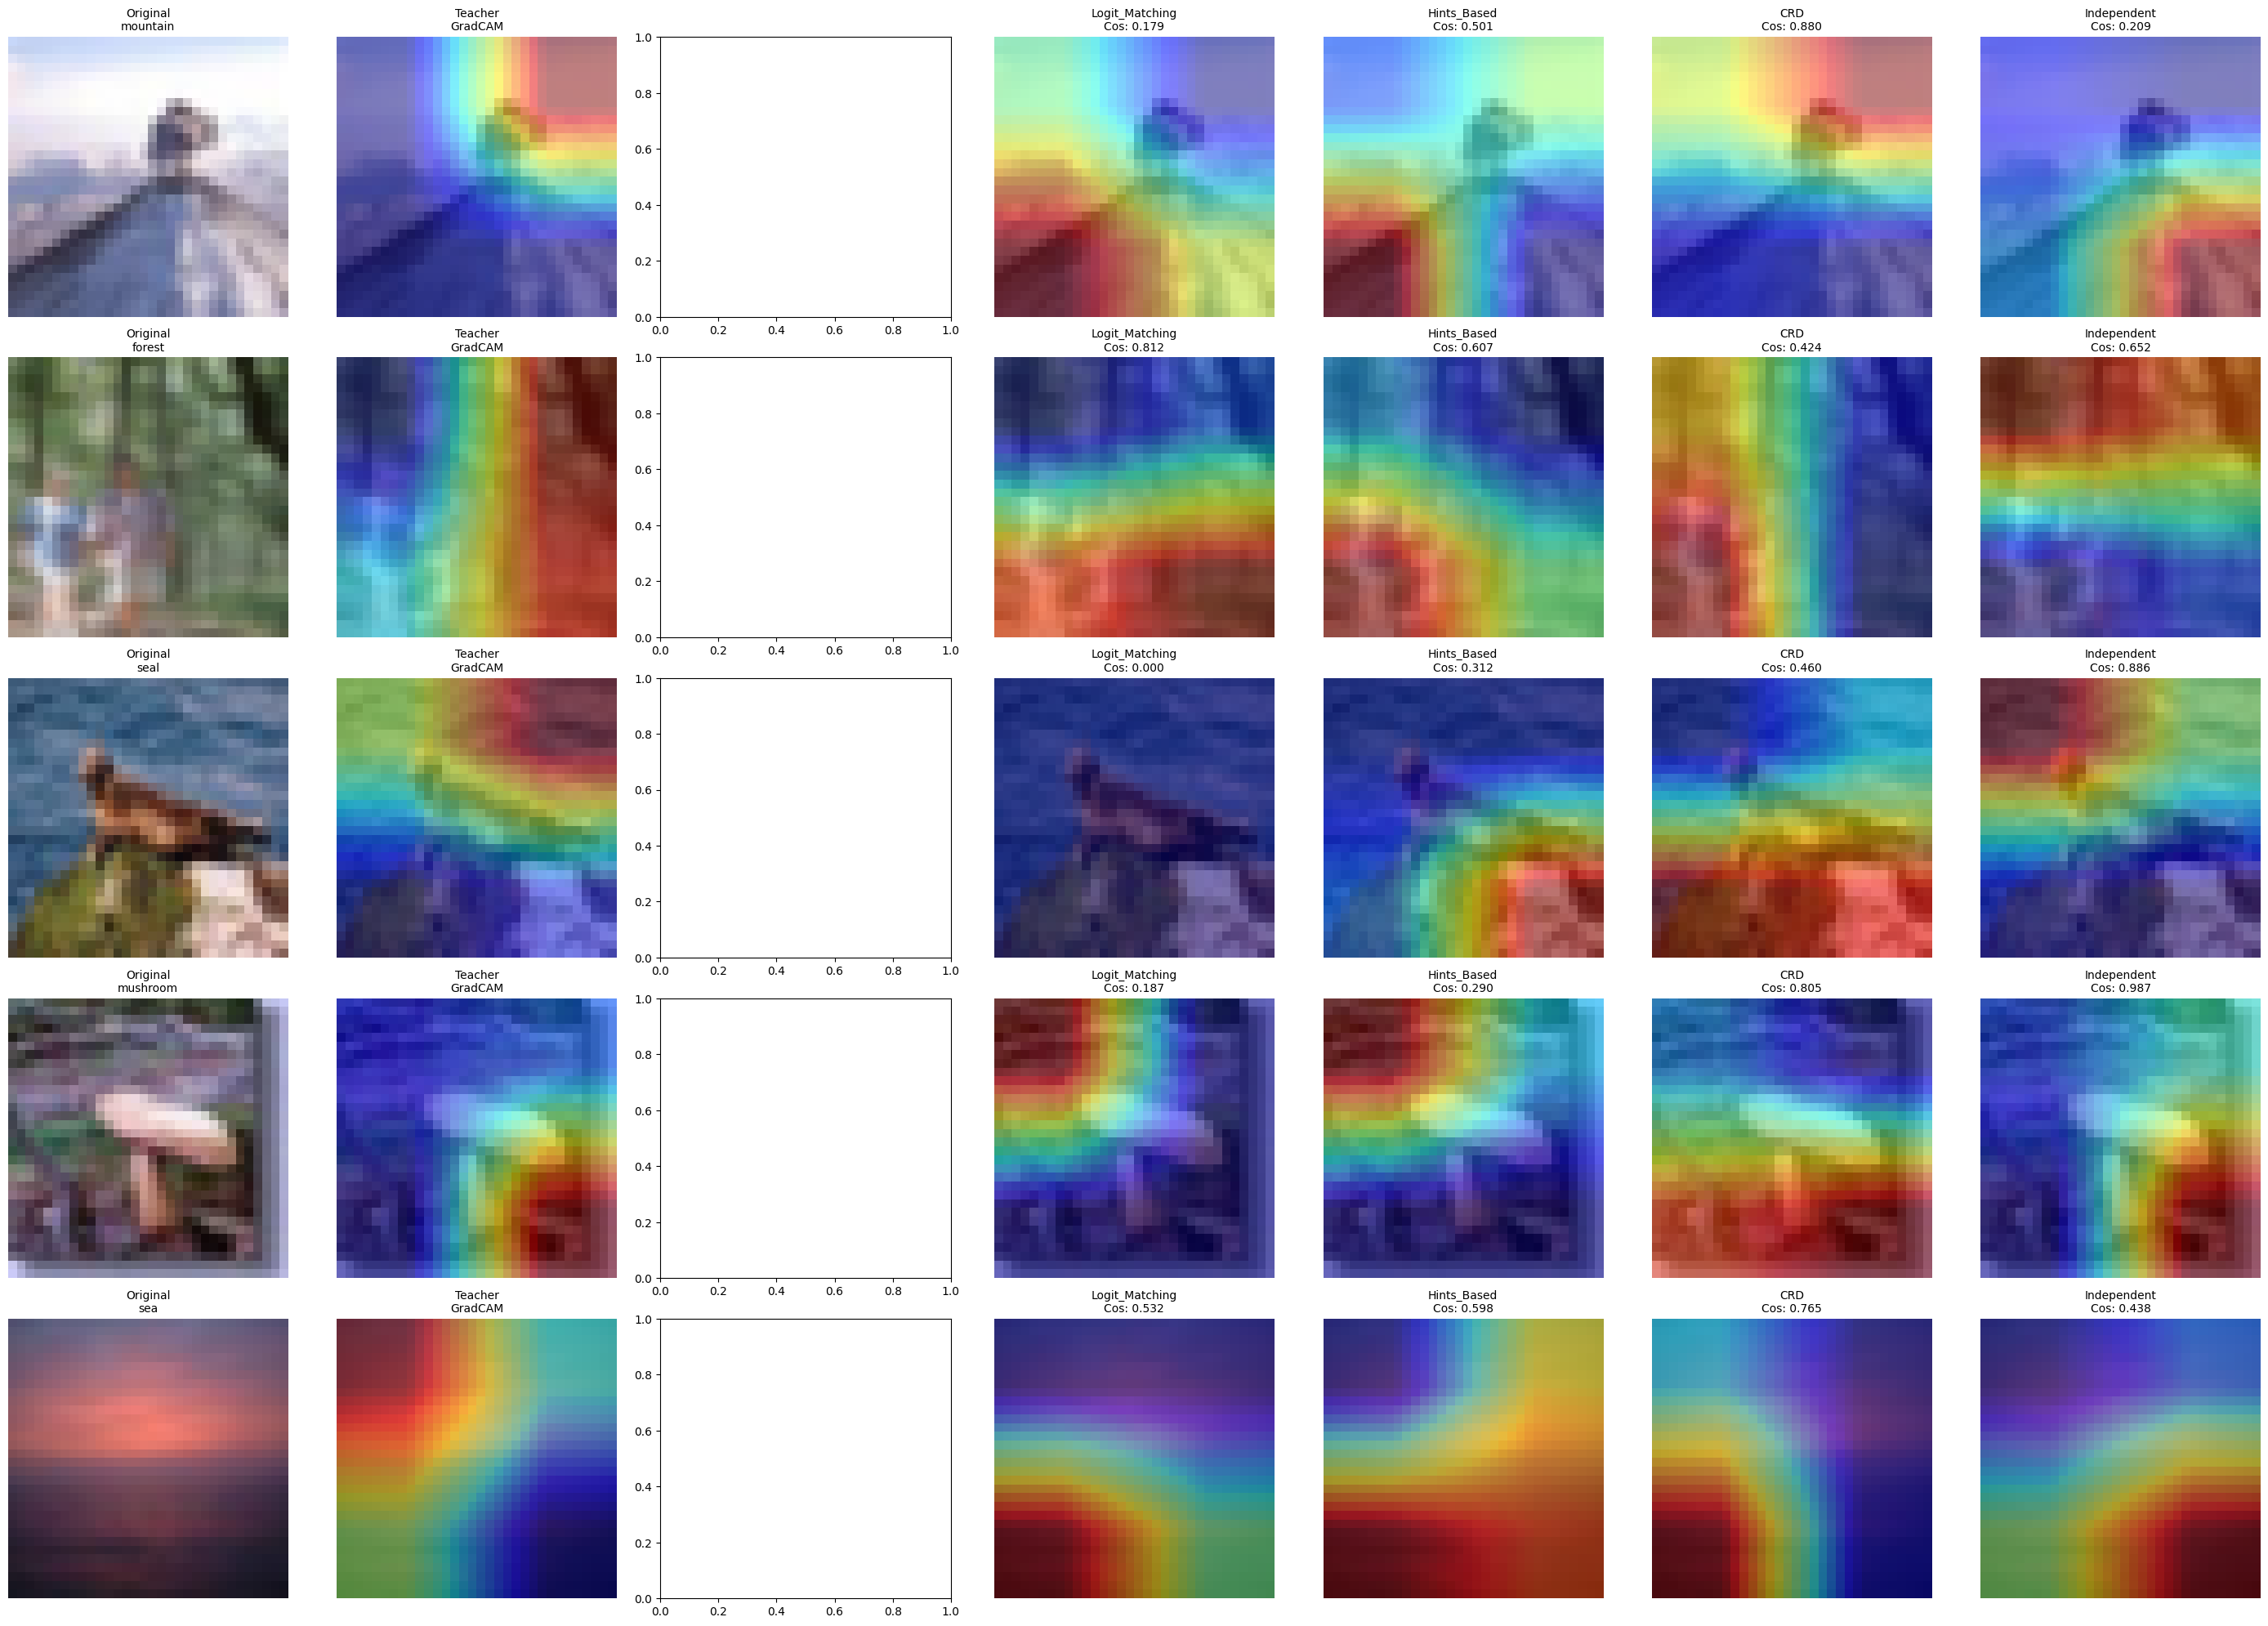


LOCALIZATION SIMILARITY QUANTIFICATION

Model                Metric          Mean       Std        Range          
----------------------------------------------------------------------
Logit_Matching       cosine          0.342      0.291      [0.000, 0.812] 
Logit_Matching       ssim            -0.014     0.198      [-0.266, 0.334]
Logit_Matching       iou             0.048      0.074      [0.000, 0.192] 
Logit_Matching       correlation     nan        nan        [nan, nan]     
Hints_Based          cosine          0.462      0.136      [0.290, 0.607] 
Hints_Based          ssim            -0.107     0.171      [-0.295, 0.214]
Hints_Based          iou             0.000      0.000      [0.000, 0.000] 
Hints_Based          correlation     -0.449     0.253      [-0.780, -0.023]
CRD                  cosine          0.667      0.188      [0.424, 0.880] 
CRD                  ssim            0.107      0.334      [-0.297, 0.525]
CRD                  iou             0.253      0.259      [0.

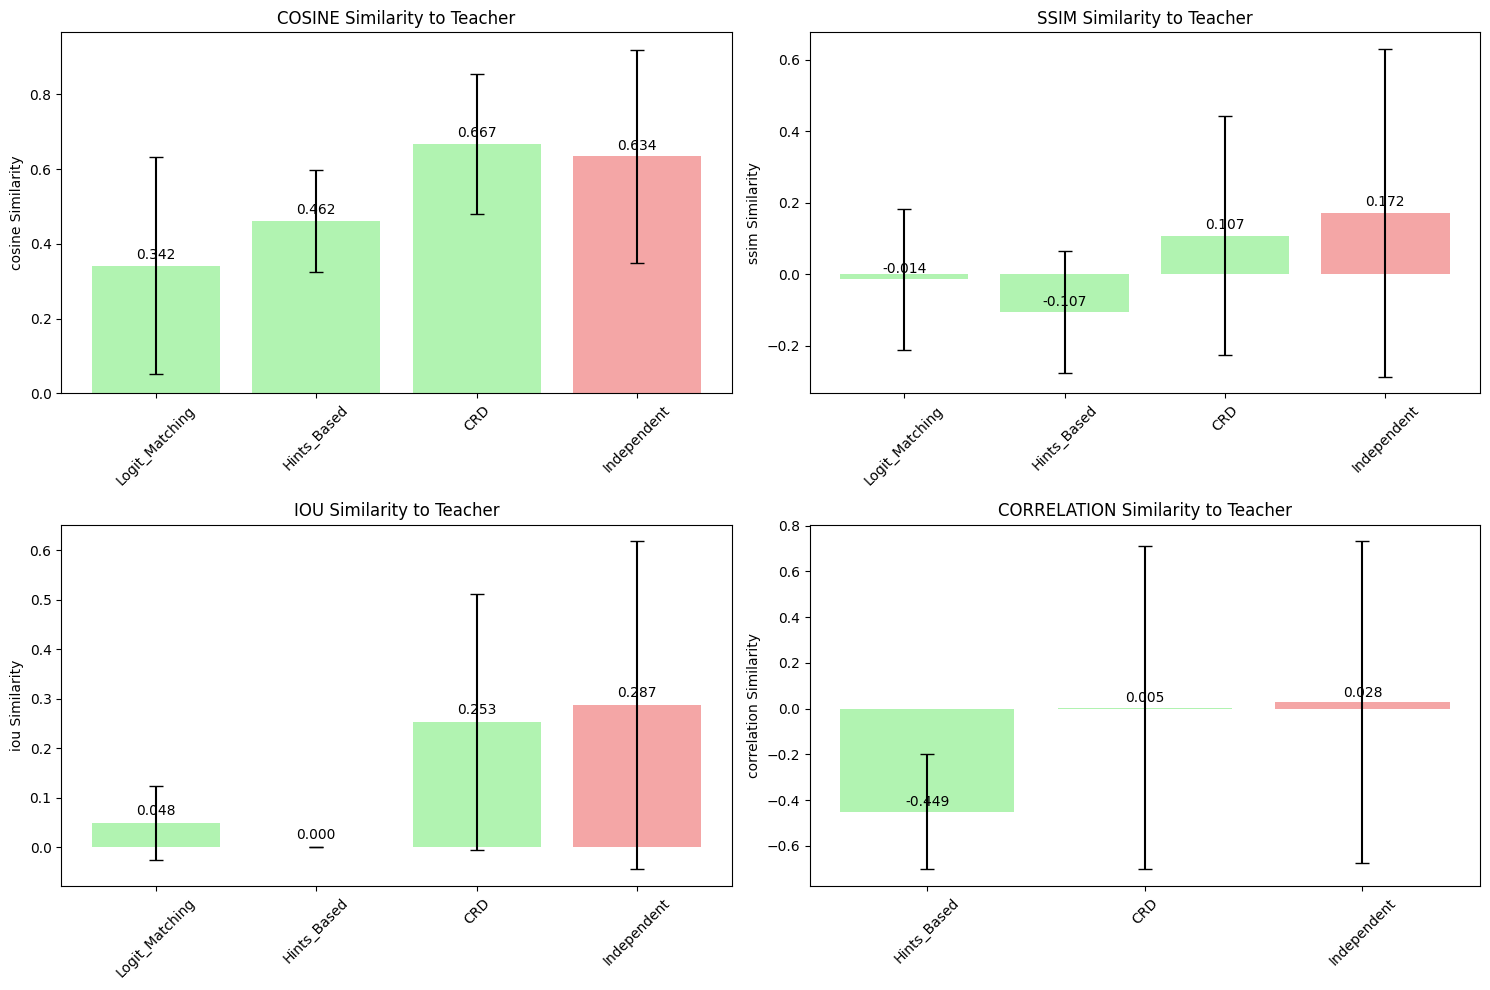


ATTENTION CONSISTENCY ANALYSIS
Processing batch 1/3...
Processing batch 2/3...
Processing batch 3/3...

Model                Mean Cosine     Std             Consistency    
-----------------------------------------------------------------
Logit_Matching       0.6127          0.3324          0.6676         
Hints_Based          0.4647          0.3654          0.6346         
CRD                  0.7286          0.1396          0.8604         
Independent          0.6686          0.3252          0.6748         

LOCALIZATION KNOWLEDGE TRANSFER - KEY FINDINGS

Best Localization Transfer: CRD (Cosine Similarity: 0.667)

Key Insights:
1. Cosine Similarity > 0.7: Excellent alignment with teacher's focus
2. Cosine Similarity 0.5-0.7: Good alignment
3. Cosine Similarity < 0.5: Poor alignment

Interpretation of Results:
- Logit_Matching: 0.342 → POOR - Different attention patterns from teacher
- Hints_Based: 0.462 → POOR - Different attention patterns from teacher
- CRD: 0.667 → GOOD - Reasona

In [ ]:
# Cell: Fixed GradCAM Implementation for Frozen Models
class GradCAM:
    """
    GradCAM implementation that works with frozen models by enabling gradients
    """
    def __init__(self, model, target_layer_name=None):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self.hooks = []

        self._register_hooks()

    def _register_hooks(self):
        """Register forward and backward hooks"""
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Find target layer
        target_layer = self._find_target_layer()
        if target_layer is None:
            raise ValueError(f"Target layer {self.target_layer_name} not found in model")

        # Register hooks
        self.hooks.append(target_layer.register_forward_hook(forward_hook))
        self.hooks.append(target_layer.register_backward_hook(backward_hook))

    def _find_target_layer(self):
        """Find the target layer for GradCAM"""
        if self.target_layer_name:
            # Look for specific layer by name
            for name, module in self.model.named_modules():
                if name == self.target_layer_name:
                    return module
        else:
            # Default: find the last convolutional layer
            conv_layers = []
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Conv2d):
                    conv_layers.append(module)
            return conv_layers[-1] if conv_layers else None

    def generate(self, input_tensor, target_class=None, reshape_size=(32, 32)):
        """Generate GradCAM heatmap - works with frozen models"""
        # Store original requires_grad state
        original_requires_grad = {}
        for param in self.model.parameters():
            original_requires_grad[param] = param.requires_grad

        # Temporarily enable gradients for all parameters
        for param in self.model.parameters():
            param.requires_grad = True

        self.model.eval()

        try:
            # Forward pass with gradients enabled
            input_tensor.requires_grad_(True)
            output = self.model(input_tensor)

            if target_class is None:
                target_class = output.argmax(dim=1)

            # Zero gradients
            self.model.zero_grad()

            # Backward pass for target class
            one_hot = torch.zeros_like(output)
            one_hot.scatter_(1, target_class.unsqueeze(1), 1.0)

            output.backward(gradient=one_hot, retain_graph=True)

            # Calculate weights (global average pooling of gradients)
            if self.gradients is not None:
                weights = self.gradients.mean(dim=(2, 3), keepdim=True)

                # Generate CAM
                cam = (weights * self.activations).sum(dim=1, keepdim=True)
                cam = F.relu(cam)

                # Interpolate to input size
                cam = F.interpolate(cam, size=reshape_size, mode='bilinear', align_corners=False)

                # Normalize
                cam = cam - cam.min()
                cam = cam / (cam.max() + 1e-8)

                return cam.squeeze().cpu().detach().numpy()
            else:
                # Fallback: return zero heatmap if gradients are None
                print("Warning: Gradients are None, returning zero heatmap")
                return np.zeros(reshape_size)

        finally:
            # Restore original requires_grad state
            for param, original_state in original_requires_grad.items():
                param.requires_grad = original_state

    def remove_hooks(self):
        """Remove registered hooks"""
        for hook in self.hooks:
            hook.remove()

def generate_gradcam_comparison_fixed(models_dict, sample_images, sample_labels, class_names, save_path, num_samples=5):
    """
    Generate comprehensive GradCAM comparison across all models - fixed for frozen models
    """
    print("\n" + "="*80)
    print("PART 4: EXAMINING LOCALIZATION KNOWLEDGE TRANSFER")
    print("="*80)

    # Select subset of samples
    if len(sample_images) > num_samples:
        indices = np.random.choice(len(sample_images), num_samples, replace=False)
        sample_images = [sample_images[i] for i in indices]
        sample_labels = [sample_labels[i] for i in indices]

    # Create figure
    num_models = len(models_dict)
    fig, axes = plt.subplots(len(sample_images), num_models + 2, figsize=(4*(num_models+2), 4*len(sample_images)))

    if len(sample_images) == 1:
        axes = axes.reshape(1, -1)

    # Store heatmaps for similarity analysis
    all_heatmaps = {model_name: [] for model_name in models_dict.keys()}
    similarity_results = {model_name: [] for model_name in models_dict.keys() if model_name != 'Teacher'}

    print("Generating GradCAM visualizations...")

    for img_idx, (image, true_label) in enumerate(zip(sample_images, sample_labels)):
        # Preprocess image for GradCAM
        image_tensor = preprocess_image_for_gradcam(image, device)

        # Denormalize for visualization
        mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.2675, 0.2565, 0.2761]).view(1, 3, 1, 1).to(device)
        image_vis = image_tensor * std + mean
        image_vis = torch.clamp(image_vis, 0, 1)
        image_vis = image_vis.squeeze(0).cpu().permute(1, 2, 0).numpy()

        # Original image
        axes[img_idx, 0].imshow(image_vis)
        axes[img_idx, 0].set_title(f'Original\n{class_names[true_label]}', fontsize=10)
        axes[img_idx, 0].axis('off')

        # Teacher GradCAM - handle frozen model
        try:
            # Create a temporary copy of teacher model for GradCAM
            teacher_gradcam = GradCAM(models_dict['Teacher'])
            teacher_heatmap = teacher_gradcam.generate(image_tensor)
            teacher_gradcam.remove_hooks()

            axes[img_idx, 1].imshow(image_vis)
            axes[img_idx, 1].imshow(teacher_heatmap, alpha=0.5, cmap='jet')
            axes[img_idx, 1].set_title('Teacher\nGradCAM', fontsize=10)
            axes[img_idx, 1].axis('off')
            all_heatmaps['Teacher'].append(teacher_heatmap)
        except Exception as e:
            print(f"Error generating teacher GradCAM: {e}")
            axes[img_idx, 1].text(0.5, 0.5, 'Teacher\nError',
                                ha='center', va='center', transform=axes[img_idx, 1].transAxes)
            axes[img_idx, 1].axis('off')
            # Create dummy heatmap for similarity calculations
            teacher_heatmap = np.zeros((32, 32))
            all_heatmaps['Teacher'].append(teacher_heatmap)

        # Model visualizations
        for model_idx, (model_name, model) in enumerate(models_dict.items(), 2):
            if model_name == 'Teacher':
                continue

            try:
                gradcam = GradCAM(model)
                heatmap = gradcam.generate(image_tensor)
                gradcam.remove_hooks()

                axes[img_idx, model_idx].imshow(image_vis)
                axes[img_idx, model_idx].imshow(heatmap, alpha=0.5, cmap='jet')

                # Calculate similarity with teacher
                similarities = calculate_heatmap_similarity(teacher_heatmap, heatmap, method='all')
                cosine_sim = similarities.get('cosine', 0)

                axes[img_idx, model_idx].set_title(f'{model_name}\nCos: {cosine_sim:.3f}', fontsize=10)
                axes[img_idx, model_idx].axis('off')

                all_heatmaps[model_name].append(heatmap)
                similarity_results[model_name].append(similarities)

            except Exception as e:
                print(f"Error generating GradCAM for {model_name}: {e}")
                axes[img_idx, model_idx].text(0.5, 0.5, f'Error\n{model_name}',
                                            ha='center', va='center', transform=axes[img_idx, model_idx].transAxes)
                axes[img_idx, model_idx].axis('off')

    plt.tight_layout()
    plt.savefig(f"{save_path}/gradcam_comparison_visual.png", dpi=300, bbox_inches='tight')
    plt.show()

    return all_heatmaps, similarity_results

def calculate_heatmap_similarity(heatmap1, heatmap2, method='cosine'):
    """
    Calculate similarity between two heatmaps using multiple metrics
    """
    # Flatten heatmaps
    h1_flat = heatmap1.flatten()
    h2_flat = heatmap2.flatten()

    similarities = {}

    # Cosine similarity
    if method == 'cosine' or method == 'all':
        cosine_sim = np.dot(h1_flat, h2_flat) / (np.linalg.norm(h1_flat) * np.linalg.norm(h2_flat) + 1e-8)
        similarities['cosine'] = cosine_sim

    # Structural Similarity Index (SSIM)
    if method == 'ssim' or method == 'all':
        try:
            from skimage.metrics import structural_similarity as ssim
            ssim_val = ssim(heatmap1, heatmap2, data_range=1.0)
            similarities['ssim'] = ssim_val
        except ImportError:
            print("scikit-image not available for SSIM calculation")

    # Intersection over Union (IoU) for binarized heatmaps
    if method == 'iou' or method == 'all':
        # Simple binarization without scikit-image
        thresh1 = np.percentile(heatmap1, 70)  # Use 70th percentile as threshold
        thresh2 = np.percentile(heatmap2, 70)
        bin1 = heatmap1 > thresh1
        bin2 = heatmap2 > thresh2

        intersection = np.logical_and(bin1, bin2).sum()
        union = np.logical_or(bin1, bin2).sum()
        iou = intersection / (union + 1e-8)
        similarities['iou'] = iou

    # Pearson correlation
    if method == 'correlation' or method == 'all':
        correlation = np.corrcoef(h1_flat, h2_flat)[0, 1]
        similarities['correlation'] = correlation

    return similarities

def preprocess_image_for_gradcam(image, device):
    """
    Preprocess image for GradCAM - handle both PIL and tensor inputs
    """
    if isinstance(image, torch.Tensor):
        # Already a tensor
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add batch dimension
        return image.to(device)
    else:
        # PIL Image - apply same transforms as test set
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        return image_tensor.to(device)

def get_diverse_sample_images_tensor(testloader, num_samples=5, num_classes=5):
    """
    Get diverse sample images as tensors from the testloader
    """
    samples_by_class = {}

    # Collect samples from different classes
    for inputs, targets in testloader:
        for i in range(inputs.size(0)):
            class_id = targets[i].item()
            if class_id not in samples_by_class:
                samples_by_class[class_id] = (inputs[i], targets[i])

            if len(samples_by_class) >= num_classes:
                break
        if len(samples_by_class) >= num_classes:
            break

    # Convert to lists
    sample_images = []
    sample_labels = []

    for class_id, (image, label) in samples_by_class.items():
        sample_images.append(image)
        sample_labels.append(label)

    # If we need more samples, add from the first batch
    if len(sample_images) < num_samples:
        for inputs, targets in testloader:
            for i in range(min(inputs.size(0), num_samples - len(sample_images))):
                sample_images.append(inputs[i])
                sample_labels.append(targets[i])
            if len(sample_images) >= num_samples:
                break

    return sample_images, sample_labels


# Cell: Fixed JSON Serialization for Localization Analysis
def analyze_attention_consistency(models_dict, testloader, device, save_path, num_batches=3):
    """
    Analyze attention consistency across multiple batches
    """
    print("\n" + "="*60)
    print("ATTENTION CONSISTENCY ANALYSIS")
    print("="*60)

    batch_similarities = {model_name: [] for model_name in models_dict.keys() if model_name != 'Teacher'}

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if batch_idx >= num_batches:
            break

        print(f"Processing batch {batch_idx + 1}/{num_batches}...")

        # Use first image in batch for analysis
        sample_image = inputs[0:1].to(device)

        # Generate teacher heatmap
        try:
            teacher_gradcam = GradCAM(models_dict['Teacher'])
            teacher_heatmap = teacher_gradcam.generate(sample_image)
            teacher_gradcam.remove_hooks()
        except Exception as e:
            print(f"Error generating teacher heatmap for batch {batch_idx}: {e}")
            continue

        # Generate student heatmaps and calculate similarities
        for model_name, model in models_dict.items():
            if model_name == 'Teacher':
                continue

            try:
                gradcam = GradCAM(model)
                student_heatmap = gradcam.generate(sample_image)
                gradcam.remove_hooks()

                similarity = calculate_heatmap_similarity(teacher_heatmap, student_heatmap, method='cosine')
                batch_similarities[model_name].append(similarity.get('cosine', 0))

            except Exception as e:
                print(f"Error in batch analysis for {model_name}: {e}")

    # Calculate consistency metrics
    print(f"\n{'Model':<20} {'Mean Cosine':<15} {'Std':<15} {'Consistency':<15}")
    print("-" * 65)

    consistency_results = {}
    for model_name, similarities in batch_similarities.items():
        if similarities:
            mean_sim = float(np.mean(similarities))  # Convert to Python float
            std_sim = float(np.std(similarities))    # Convert to Python float
            consistency = float(1 - std_sim)         # Convert to Python float

            consistency_results[model_name] = {
                'mean_cosine': mean_sim,
                'std': std_sim,
                'consistency': consistency
            }

            print(f"{model_name:<20} {mean_sim:<15.4f} {std_sim:<15.4f} {consistency:<15.4f}")

    # Save results with proper serialization
    serializable_results = {}
    for model_name, metrics in consistency_results.items():
        serializable_results[model_name] = {
            'mean_cosine': float(metrics['mean_cosine']),
            'std': float(metrics['std']),
            'consistency': float(metrics['consistency'])
        }

    with open(f"{save_path}/attention_consistency.json", 'w') as f:
        json.dump(serializable_results, f, indent=2)

    return consistency_results

def analyze_localization_similarity(similarity_results, save_path):
    """
    Analyze and quantify localization similarity across models with proper JSON serialization
    """
    print("\n" + "="*60)
    print("LOCALIZATION SIMILARITY QUANTIFICATION")
    print("="*60)

    # Calculate average similarities
    avg_similarities = {}

    for model_name, similarities_list in similarity_results.items():
        if not similarities_list:
            continue

        avg_similarities[model_name] = {}
        for metric in similarities_list[0].keys():
            values = [s[metric] for s in similarities_list if metric in s]
            if values:
                avg_similarities[model_name][metric] = {
                    'mean': float(np.mean(values)),    # Convert to Python float
                    'std': float(np.std(values)),      # Convert to Python float
                    'min': float(np.min(values)),      # Convert to Python float
                    'max': float(np.max(values))       # Convert to Python float
                }

    # Print results
    print(f"\n{'Model':<20} {'Metric':<15} {'Mean':<10} {'Std':<10} {'Range':<15}")
    print("-" * 70)

    for model_name, metrics in avg_similarities.items():
        for metric, stats in metrics.items():
            range_str = f"[{stats['min']:.3f}, {stats['max']:.3f}]"
            print(f"{model_name:<20} {metric:<15} {stats['mean']:<10.3f} {stats['std']:<10.3f} {range_str:<15}")

    # Create visualization
    metrics_to_plot = ['cosine', 'ssim', 'iou', 'correlation']
    available_metrics = []
    for metric in metrics_to_plot:
        if any(metric in model_metrics for model_metrics in avg_similarities.values()):
            available_metrics.append(metric)

    if available_metrics:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for idx, metric in enumerate(available_metrics):
            if idx >= len(axes):
                break

            models = []
            means = []
            stds = []

            for model_name, metrics in avg_similarities.items():
                if metric in metrics:
                    models.append(model_name)
                    means.append(metrics[metric]['mean'])
                    stds.append(metrics[metric]['std'])

            if models:
                bars = axes[idx].bar(models, means, yerr=stds, capsize=5, alpha=0.7,
                                   color=['lightgreen' if 'Independent' not in model else 'lightcoral' for model in models])
                axes[idx].set_title(f'{metric.upper()} Similarity to Teacher')
                axes[idx].set_ylabel(f'{metric} Similarity')
                axes[idx].tick_params(axis='x', rotation=45)

                # Add value labels
                for bar, mean in zip(bars, means):
                    axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                 f'{mean:.3f}', ha='center', va='bottom')

        # Hide unused subplots
        for idx in range(len(available_metrics), len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.savefig(f"{save_path}/localization_similarity_quantification.png", dpi=300, bbox_inches='tight')
        plt.show()

    # Save results with proper serialization
    serializable_results = {}
    for model_name, metrics in avg_similarities.items():
        serializable_results[model_name] = {}
        for metric, stats in metrics.items():
            serializable_results[model_name][metric] = {
                'mean': float(stats['mean']),
                'std': float(stats['std']),
                'min': float(stats['min']),
                'max': float(stats['max'])
            }

    with open(f"{save_path}/localization_similarity_metrics.json", 'w') as f:
        json.dump(serializable_results, f, indent=2)

    return avg_similarities

# Main execution for Part 4 (Fixed JSON Serialization)
print("=== PART 4: EXAMINING LOCALIZATION KNOWLEDGE TRANSFER ===")
save_path_part4 = f"{base_path}/part_4"
os.makedirs(save_path_part4, exist_ok=True)

# Ensure all models are loaded
models_dict = {
    'Teacher': teacher_model,
    'Logit_Matching': student_lm,
    'Hints_Based': student_hints,
    'CRD': student_crd,
    'Independent': student_independent
}

# Load CIFAR-100 testset for class names
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
class_names = testset.classes

# Get diverse samples as tensors directly from testloader
sample_images, sample_labels = get_diverse_sample_images_tensor(testloader, num_samples=5)

# Generate comprehensive GradCAM comparison with fixed implementation
all_heatmaps, similarity_results = generate_gradcam_comparison_fixed(
    models_dict, sample_images, sample_labels, class_names, save_path_part4
)

# Analyze localization similarity
if similarity_results:
    avg_similarities = analyze_localization_similarity(similarity_results, save_path_part4)

    # Analyze attention consistency across batches
    consistency_results = analyze_attention_consistency(
        models_dict, testloader, device, save_path_part4, num_batches=3
    )

    # Final analysis and conclusions
    print("\n" + "="*80)
    print("LOCALIZATION KNOWLEDGE TRANSFER - KEY FINDINGS")
    print("="*80)

    # Identify best method for localization transfer
    if avg_similarities:
        best_method = max(avg_similarities.keys(),
                         key=lambda x: avg_similarities[x].get('cosine', {}).get('mean', 0)
                         if 'cosine' in avg_similarities[x] else 0)

        best_cosine = avg_similarities[best_method].get('cosine', {}).get('mean', 0)

        print(f"\nBest Localization Transfer: {best_method} (Cosine Similarity: {best_cosine:.3f})")

        print("\nKey Insights:")
        print("1. Cosine Similarity > 0.7: Excellent alignment with teacher's focus")
        print("2. Cosine Similarity 0.5-0.7: Good alignment")
        print("3. Cosine Similarity < 0.5: Poor alignment")

        print("\nInterpretation of Results:")
        for model_name, metrics in avg_similarities.items():
            cosine_mean = metrics.get('cosine', {}).get('mean', 0)
            if cosine_mean > 0.7:
                assessment = "EXCELLENT - Very similar attention patterns to teacher"
            elif cosine_mean > 0.5:
                assessment = "GOOD - Reasonable alignment with teacher's focus"
            else:
                assessment = "POOR - Different attention patterns from teacher"

            print(f"- {model_name}: {cosine_mean:.3f} → {assessment}")

    # Save comprehensive results with proper serialization
    final_results = {
        'average_similarities': {},
        'attention_consistency': {}
    }

    # Convert average_similarities to serializable format
    if avg_similarities:
        for model_name, metrics in avg_similarities.items():
            final_results['average_similarities'][model_name] = {}
            for metric, stats in metrics.items():
                final_results['average_similarities'][model_name][metric] = {
                    'mean': float(stats['mean']),
                    'std': float(stats['std']),
                    'min': float(stats['min']),
                    'max': float(stats['max'])
                }

    # Convert consistency_results to serializable format
    if consistency_results:
        for model_name, metrics in consistency_results.items():
            final_results['attention_consistency'][model_name] = {
                'mean_cosine': float(metrics['mean_cosine']),
                'std': float(metrics['std']),
                'consistency': float(metrics['consistency'])
            }

    # Add key findings
    if avg_similarities:
        final_results['key_findings'] = {
            'best_method': best_method,
            'best_cosine_similarity': float(best_cosine)
        }

    with open(f"{save_path_part4}/localization_transfer_comprehensive.json", 'w') as f:
        json.dump(final_results, f, indent=2)

print(f"\nPart 4 completed! Comprehensive localization analysis saved to {save_path_part4}")

print("\n" + "="*80)
print("SUMMARY OF LOCALIZATION TRANSFER RESULTS")
print("="*80)

if 'consistency_results' in locals() and consistency_results:
    print("\nAttention Consistency Results:")
    print("-" * 50)
    for model_name, metrics in consistency_results.items():
        print(f"{model_name}:")
        print(f"  Mean Cosine Similarity: {metrics['mean_cosine']:.4f}")
        print(f"  Standard Deviation: {metrics['std']:.4f}")
        print(f"  Consistency Score: {metrics['consistency']:.4f}")
        print()

if 'avg_similarities' in locals() and avg_similarities:
    print("\nOverall Localization Similarity:")
    print("-" * 40)
    for model_name, metrics in avg_similarities.items():
        if 'cosine' in metrics:
            print(f"{model_name}: {metrics['cosine']['mean']:.4f} cosine similarity")

# Part 5

In [ ]:
# Cell: Color Invariance Analysis with CRD
def create_color_jitter_transform(jitter_strength=0.8):
    """
    Create color jitter transform with configurable strength
    """
    return transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(
                brightness=jitter_strength,
                contrast=jitter_strength,
                saturation=jitter_strength,
                hue=0.2
            )
        ], p=1.0),  # Always apply color jitter
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def create_color_invariant_teacher_training_transform():
    """
    Create training transform for color-invariant teacher with heavy color jitter
    """
    return transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.3)
        ], p=0.9),  # High probability of color jitter
        transforms.RandomGrayscale(p=0.2),  # Sometimes convert to grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def finetune_color_invariant_teacher(teacher_model, trainloader, testloader, save_path, total_epochs=30):
    """
    Finetune teacher model to be color-invariant using heavy color augmentations
    """
    model_name = "color_invariant_teacher"


    teacher_model = teacher_model.to(device)

    # Check if training is already complete
    latest_epoch = get_checkpoint_epoch(model_name, save_path)
    if latest_epoch >= total_epochs:
        print(f"Color-invariant teacher training already completed (epoch {latest_epoch})")
        final_checkpoint_path = f"{save_path}/{model_name}_epoch_{total_epochs:03d}.pth"
        checkpoint = torch.load(final_checkpoint_path)
        teacher_model.load_state_dict(checkpoint['model_state_dict'])
        return teacher_model

    # Unfreeze the teacher model for fine-tuning
    for param in teacher_model.parameters():
        param.requires_grad = True

    teacher_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # Lower LR for fine-tuning
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)

    # Create color-jittered training dataset
    color_transform = create_color_invariant_teacher_training_transform()
    color_trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=color_transform)
    color_trainloader = DataLoader(color_trainset, batch_size=128, shuffle=True, num_workers=2)

    # Load checkpoint if exists
    start_epoch = 0
    best_acc = 0
    train_accuracies = []
    test_accuracies = []

    teacher_model, optimizer, scheduler, start_epoch, best_acc, train_accuracies, test_accuracies, loaded = load_checkpoint(
        teacher_model, optimizer, scheduler, model_name, save_path)

    if loaded:
        print(f"Resuming color-invariant teacher training from epoch {start_epoch}")
        start_epoch += 1

    if start_epoch >= total_epochs:
        print(f"Training already completed (epoch {start_epoch})")
        return teacher_model

    print(f"Finetuning Color-Invariant Teacher from epoch {start_epoch} to {total_epochs}...")

    for epoch in range(start_epoch, total_epochs):
        teacher_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(color_trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = teacher_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        test_acc = evaluate(teacher_model, testloader, device)
        scheduler.step()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        # Save checkpoint every 10 epochs or at final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            checkpoint_path = save_checkpoint(
                teacher_model, optimizer, scheduler, epoch + 1, best_acc,
                train_accuracies, test_accuracies, model_name, save_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch+1:3d} | Train Loss: {running_loss/len(color_trainloader):.3f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

    print(f'Color-Invariant Teacher Best Test Accuracy: {best_acc:.2f}%')

    # Freeze the teacher again after fine-tuning
    for param in teacher_model.parameters():
        param.requires_grad = False
    teacher_model.eval()

    return teacher_model

def evaluate_color_invariance(models_dict, original_loader, jittered_loader, device):
    """
    Evaluate model performance on original and color-jittered data
    """
    print(f"\n{'Model':<25} {'Original Acc':<12} {'Jittered Acc':<12} {'Accuracy Drop':<15} {'Robustness %':<15}")
    print("-" * 85)

    results = {}

    for model_name, model in models_dict.items():
        original_acc = evaluate(model, original_loader, device)
        jittered_acc = evaluate(model, jittered_loader, device)

        accuracy_drop = original_acc - jittered_acc
        robustness = (jittered_acc / original_acc) * 100 if original_acc > 0 else 0

        results[model_name] = {
            'original_accuracy': float(original_acc),
            'jittered_accuracy': float(jittered_acc),
            'accuracy_drop': float(accuracy_drop),
            'robustness_percentage': float(robustness)
        }

        print(f"{model_name:<25} {original_acc:<12.2f} {jittered_acc:<12.2f} {accuracy_drop:<15.2f} {robustness:<15.2f}")

    return results

def train_students_with_color_invariant_teacher(teacher_model, save_path, total_epochs=50):
    """
    Train students using the color-invariant teacher with different KD methods
    """
    print("\n" + "="*80)
    print("TRAINING STUDENTS WITH COLOR-INVARIANT TEACHER")
    print("="*80)

    # Initialize student models
    student_lm_color = VGG11().to(device)
    student_hints_color = VGG11().to(device)
    student_crd_color = VGG11().to(device)

    results = {}

    # Train with Logit Matching
    print("\n=== Training with Color-Invariant Teacher (Logit Matching) ===")
    lm_loss = LogitMatchingLoss(alpha=0.7, temperature=4)
    train_acc_lm, test_acc_lm, best_lm = train_with_distillation(
        student_lm_color, teacher_model, trainloader, testloader, lm_loss,
        "color_invariant_lm", save_path, total_epochs)
    results['LM_Color_Invariant'] = (student_lm_color, best_lm)

    # Train with Hints
    print("\n=== Training with Color-Invariant Teacher (Hints) ===")
    hints_loss = HintLoss(alpha=0.7)
    train_acc_hints, test_acc_hints, best_hints = train_with_distillation(
        student_hints_color, teacher_model, trainloader, testloader, hints_loss,
        "color_invariant_hints", save_path, total_epochs)
    results['Hints_Color_Invariant'] = (student_hints_color, best_hints)

    # Train with CRD
    print("\n=== Training with Color-Invariant Teacher (CRD) ===")
    crd_loss = CRDLoss(alpha=0.7, temperature=0.1, projection_dim=128)
    train_acc_crd, test_acc_crd, best_crd = train_with_distillation(
        student_crd_color, teacher_model, trainloader, testloader, crd_loss,
        "color_invariant_crd", save_path, total_epochs)
    results['CRD_Color_Invariant'] = (student_crd_color, best_crd)

    return results

def analyze_color_invariance_transfer(original_teacher, color_invariant_teacher, students_dict,
                                    original_loader, jittered_loader, device, save_path):
    """
    Comprehensive analysis of color invariance transfer
    """
    print("\n" + "="*80)
    print("PART 5: COLOR INVARIANCE TRANSFER ANALYSIS")
    print("="*80)

    # Create models dictionary for evaluation
    evaluation_models = {
        'Original_Teacher': original_teacher,
        'Color_Invariant_Teacher': color_invariant_teacher,
    }

    # Add students trained with color-invariant teacher
    for student_name, (student_model, accuracy) in students_dict.items():
        evaluation_models[student_name] = student_model

    # Add original students for comparison (if available)
    try:
        evaluation_models['LM_Original'] = student_lm
        evaluation_models['Hints_Original'] = student_hints
        evaluation_models['CRD_Original'] = student_crd
        evaluation_models['Independent_Original'] = student_independent
    except:
        print("Note: Original students not available for comparison")

    # Evaluate all models
    color_results = evaluate_color_invariance(evaluation_models, original_loader, jittered_loader, device)

    # Create visualization
    plot_color_invariance_analysis(color_results, save_path)

    # Statistical analysis
    perform_color_invariance_statistical_analysis(color_results, save_path)

    return color_results

def plot_color_invariance_analysis(color_results, save_path):
    """
    Create comprehensive visualization of color invariance analysis
    """
    # Plot 1: Accuracy comparison
    plt.figure(figsize=(15, 5))

    # Subplot 1: Original vs Jittered Accuracy
    plt.subplot(1, 3, 1)
    models = list(color_results.keys())
    original_accs = [color_results[model]['original_accuracy'] for model in models]
    jittered_accs = [color_results[model]['jittered_accuracy'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, original_accs, width, label='Original', alpha=0.7, color='blue')
    plt.bar(x + width/2, jittered_accs, width, label='Color-Jittered', alpha=0.7, color='red')

    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Original vs Color-Jittered Accuracy')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Subplot 2: Accuracy Drop
    plt.subplot(1, 3, 2)
    accuracy_drops = [color_results[model]['accuracy_drop'] for model in models]

    colors = ['green' if drop < 5 else 'orange' if drop < 10 else 'red' for drop in accuracy_drops]
    bars = plt.bar(models, accuracy_drops, color=colors, alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Accuracy Drop (%)')
    plt.title('Color Invariance: Accuracy Drop\n(Green=Good, Red=Poor)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, drop in zip(bars, accuracy_drops):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{drop:.1f}%', ha='center', va='bottom')

    # Subplot 3: Robustness Percentage
    plt.subplot(1, 3, 3)
    robustness = [color_results[model]['robustness_percentage'] for model in models]

    colors = ['green' if robust > 95 else 'orange' if robust > 90 else 'red' for robust in robustness]
    bars = plt.bar(models, robustness, color=colors, alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Robustness (%)')
    plt.title('Color Invariance Robustness\n(% of original performance)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, robust in zip(bars, robustness):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{robust:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"{save_path}/color_invariance_comprehensive.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Focus on KD methods comparison
    kd_models = [model for model in models if any(x in model for x in ['LM', 'Hints', 'CRD'])]
    if len(kd_models) >= 3:
        plt.figure(figsize=(12, 4))

        # Extract data for KD methods
        kd_accuracy_drops = [color_results[model]['accuracy_drop'] for model in kd_models]
        kd_robustness = [color_results[model]['robustness_percentage'] for model in kd_models]

        # Accuracy drop comparison
        plt.subplot(1, 2, 1)
        bars = plt.bar(kd_models, kd_accuracy_drops,
                      color=['lightblue', 'lightgreen', 'gold'], alpha=0.7)
        plt.ylabel('Accuracy Drop (%)')
        plt.title('KD Methods: Color Invariance\n(Lower = Better)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        for bar, drop in zip(bars, kd_accuracy_drops):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{drop:.1f}%', ha='center', va='bottom')

        # Robustness comparison
        plt.subplot(1, 2, 2)
        bars = plt.bar(kd_models, kd_robustness,
                      color=['lightblue', 'lightgreen', 'gold'], alpha=0.7)
        plt.ylabel('Robustness (%)')
        plt.title('KD Methods: Color Robustness\n(Higher = Better)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        for bar, robust in zip(bars, kd_robustness):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{robust:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig(f"{save_path}/kd_methods_color_invariance.png", dpi=300, bbox_inches='tight')
        plt.show()

def perform_color_invariance_statistical_analysis(color_results, save_path):
    """
    Perform statistical analysis of color invariance results
    """
    print("\n" + "="*60)
    print("COLOR INVARIANCE STATISTICAL ANALYSIS")
    print("="*60)

    # Find best performing methods
    print("\nBest Performing Models:")
    print("-" * 50)

    # Best robustness (highest percentage)
    best_robust = max(color_results.items(),
                     key=lambda x: x[1]['robustness_percentage'])
    print(f"Best Robustness: {best_robust[0]} ({best_robust[1]['robustness_percentage']:.2f}%)")

    # Least accuracy drop (most color invariant)
    best_invariant = min(color_results.items(),
                        key=lambda x: x[1]['accuracy_drop'])
    print(f"Most Color Invariant: {best_invariant[0]} ({best_invariant[1]['accuracy_drop']:.2f}% drop)")

    # Compare CRD with other methods
    crd_models = [model for model in color_results.keys() if 'CRD' in model]
    other_models = [model for model in color_results.keys() if 'CRD' not in model and any(x in model for x in ['LM', 'Hints'])]

    if crd_models and other_models:
        print(f"\nCRD vs Other KD Methods Comparison:")
        print("-" * 40)

        crd_drop = np.mean([color_results[model]['accuracy_drop'] for model in crd_models])
        other_drop = np.mean([color_results[model]['accuracy_drop'] for model in other_models])

        crd_robust = np.mean([color_results[model]['robustness_percentage'] for model in crd_models])
        other_robust = np.mean([color_results[model]['robustness_percentage'] for model in other_models])

        print(f"CRD Methods - Avg Drop: {crd_drop:.2f}%, Avg Robustness: {crd_robust:.2f}%")
        print(f"Other KD Methods - Avg Drop: {other_drop:.2f}%, Avg Robustness: {other_robust:.2f}%")

        improvement_drop = other_drop - crd_drop
        improvement_robust = crd_robust - other_robust

        print(f"CRD Improvement - Drop: {improvement_drop:+.2f}%, Robustness: {improvement_robust:+.2f}%")

    # Teacher comparison
    if 'Original_Teacher' in color_results and 'Color_Invariant_Teacher' in color_results:
        original_drop = color_results['Original_Teacher']['accuracy_drop']
        invariant_drop = color_results['Color_Invariant_Teacher']['accuracy_drop']

        print(f"\nTeacher Comparison:")
        print(f"Original Teacher Drop: {original_drop:.2f}%")
        print(f"Color-Invariant Teacher Drop: {invariant_drop:.2f}%")
        print(f"Improvement: {original_drop - invariant_drop:.2f}%")

# Main execution for Part 5
print("=== PART 5: CHECKING FOR COLOR INVARIANCE WITH CRD ===")
save_path_part5 = f"{base_path}/part_5"
os.makedirs(save_path_part5, exist_ok=True)

# Step 1: Create color-jittered validation set
print("Creating color-jittered validation set...")
color_jitter_transform = create_color_jitter_transform(jitter_strength=0.8)
color_jitter_testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=color_jitter_transform)
color_jitter_testloader = DataLoader(color_jitter_testset, batch_size=128, shuffle=False)

# Step 2: Finetune teacher to be color-invariant
print("\nStep 1: Finetuning color-invariant teacher...")
color_invariant_teacher = get_vgg16_teacher()  # Get fresh teacher
color_invariant_teacher = finetune_color_invariant_teacher(
    color_invariant_teacher, trainloader, testloader, save_path_part5, total_epochs=30)

# Step 3: Train students with color-invariant teacher
print("\nStep 2: Training students with color-invariant teacher...")
students_trained_with_color_teacher = train_students_with_color_invariant_teacher(
    color_invariant_teacher, save_path_part5, total_epochs=50)

# Step 4: Comprehensive analysis
print("\nStep 3: Analyzing color invariance transfer...")
color_invariance_results = analyze_color_invariance_transfer(
    teacher_model,  # Original teacher
    color_invariant_teacher,  # Color-invariant teacher
    students_trained_with_color_teacher,  # Students trained with color-invariant teacher
    testloader,  # Original validation
    color_jitter_testloader,  # Color-jittered validation
    device,
    save_path_part5
)

# Final conclusions
print("\n" + "="*80)
print("COLOR INVARIANCE TRANSFER - KEY FINDINGS")
print("="*80)

if color_invariance_results:
    # Find best student method for color invariance
    student_methods = [model for model in color_invariance_results.keys()
                      if any(x in model for x in ['LM', 'Hints', 'CRD'])]

    if student_methods:
        best_student = min(student_methods,
                          key=lambda x: color_invariance_results[x]['accuracy_drop'])
        best_drop = color_invariance_results[best_student]['accuracy_drop']
        best_robustness = color_invariance_results[best_student]['robustness_percentage']

        print(f"\nBest Color-Invariant Student: {best_student}")
        print(f"  - Accuracy Drop: {best_drop:.2f}%")
        print(f"  - Robustness: {best_robustness:.2f}%")

        # Check if CRD is particularly effective
        crd_methods = [model for model in student_methods if 'CRD' in model]
        if crd_methods:
            crd_drop = color_invariance_results[crd_methods[0]]['accuracy_drop']
            print(f"\nCRD Performance:")
            print(f"  - Accuracy Drop: {crd_drop:.2f}%")

            if 'Independent_Original' in color_invariance_results:
                independent_drop = color_invariance_results['Independent_Original']['accuracy_drop']
                improvement = independent_drop - crd_drop
                print(f"  - Improvement over Independent: {improvement:.2f}%")

            if crd_drop <= best_drop + 1.0:  # Within 1% of best
                print(f"  → CRD is highly effective for color invariance transfer!")
            else:
                print(f"  → CRD shows moderate effectiveness for color invariance transfer")

        print("\nInterpretation:")
        print("• Accuracy Drop < 5%: Excellent color invariance")
        print("• Accuracy Drop 5-10%: Good color invariance")
        print("• Accuracy Drop > 10%: Poor color invariance")
        print("• Higher robustness % indicates better preservation of performance under color variations")

# Save comprehensive results
final_results = {
    'color_invariance_metrics': {},
    'key_findings': {}
}

# Convert results to serializable format
for model_name, metrics in color_invariance_results.items():
    final_results['color_invariance_metrics'][model_name] = {
        'original_accuracy': float(metrics['original_accuracy']),
        'jittered_accuracy': float(metrics['jittered_accuracy']),
        'accuracy_drop': float(metrics['accuracy_drop']),
        'robustness_percentage': float(metrics['robustness_percentage'])
    }

# Add key findings
if 'best_student' in locals():
    final_results['key_findings'] = {
        'best_color_invariant_student': best_student,
        'best_accuracy_drop': float(best_drop),
        'best_robustness': float(best_robustness)
    }

with open(f"{save_path_part5}/color_invariance_comprehensive.json", 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\nPart 5 completed! Color invariance analysis saved to {save_path_part5}")

=== PART 5: CHECKING FOR COLOR INVARIANCE WITH CRD ===
Creating color-jittered validation set...

Step 1: Finetuning color-invariant teacher...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Teacher model loaded and frozen successfully!
Finetuning Color-Invariant Teacher from epoch 0 to 30...
Epoch:   5 | Train Loss: 0.828 | Train Acc: 80.32% | Test Acc: 70.34%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_teacher_epoch_010.pth
Epoch:  10 | Train Loss: 0.661 | Train Acc: 83.99% | Test Acc: 70.79%
Epoch:  15 | Train Loss: 0.577 | Train Acc: 85.91% | Test Acc: 70.69%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_teacher_epoch_020.pth
Epoch:  20 | Train Loss: 0.465 | Train Acc: 88.60% | Test Acc: 71.07%
Epoch:  25 | Train Loss: 0.446 | Train Acc: 88.96% | Test Acc: 71.20%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_teacher_epoch_030.pth
Epoch:  30 | Train Loss: 0.425 | Train Acc: 89.36% | Test Acc: 71.20%
Color-Invariant Teacher Best Test Accuracy: 71.32%

Step 2: Training students with color-invariant teacher...

TRAINING STUDENTS WITH COLOR-INVARIANT TEACHER

===

KeyboardInterrupt: 

=== PART 5: CHECKING FOR COLOR INVARIANCE WITH CRD ===
Creating color-jittered validation set...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Teacher model loaded and frozen successfully!


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Teacher model loaded and frozen successfully!

Step 2: Training students with color-invariant teacher...

TRAINING STUDENTS WITH COLOR-INVARIANT TEACHER

=== Training with Color-Invariant Teacher (Logit Matching) ===
Training already completed for color_invariant_lm (epoch 50)

=== Training with Color-Invariant Teacher (Hints) ===
Training already completed for color_invariant_hints (epoch 50)

=== Training with Color-Invariant Teacher (CRD) ===
Training with color_invariant_crd from epoch 0 to 50...
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_crd_epoch_010.pth
Epoch:  10 | Train Loss: 2.446 | Train Acc: 35.87% | Test Acc: 32.44%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_crd_epoch_020.pth
Epoch:  20 | Train Loss: 2.004 | Train Acc: 46.94% | Test Acc: 46.21%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_5/color_invariant_crd_epoch_030.pth
Epoch:  30 | Train Loss: 1.856 | Train Acc: 51.14% 

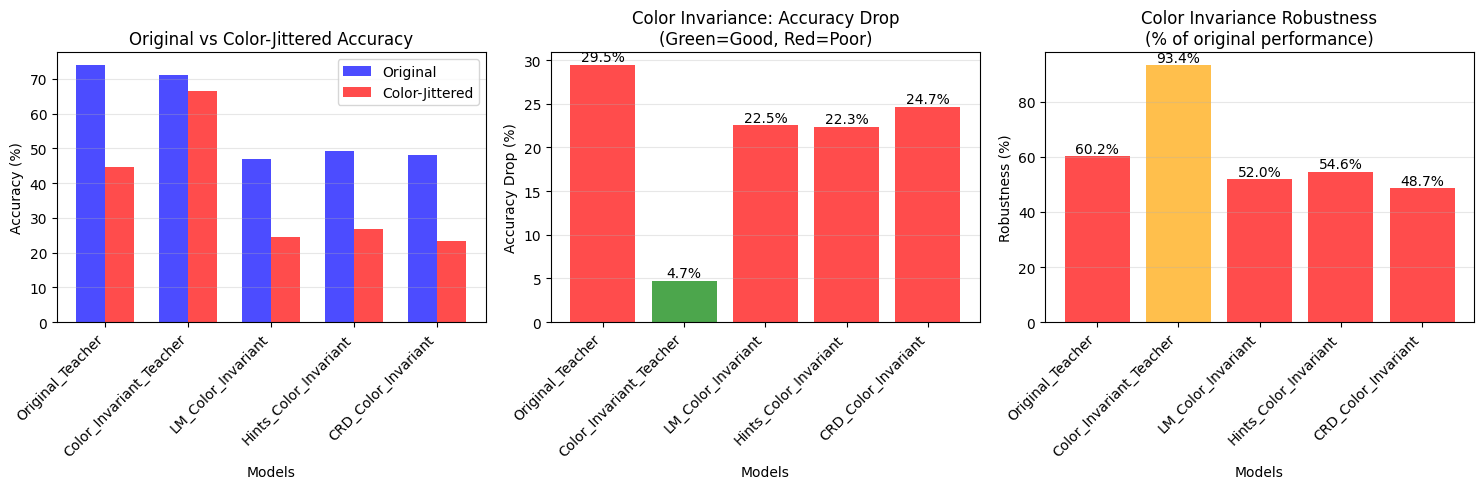

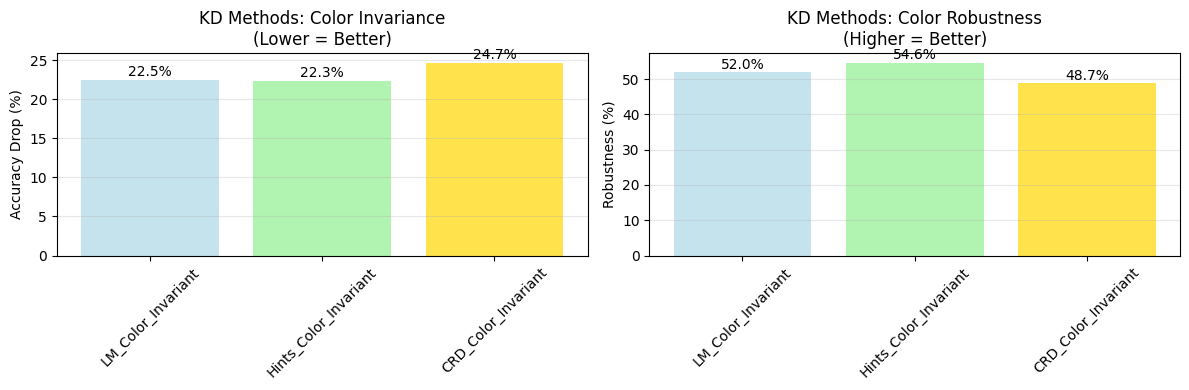


COLOR INVARIANCE STATISTICAL ANALYSIS

Best Performing Models:
--------------------------------------------------
Best Robustness: Color_Invariant_Teacher (93.36%)
Most Color Invariant: Color_Invariant_Teacher (4.73% drop)

CRD vs Other KD Methods Comparison:
----------------------------------------
CRD Methods - Avg Drop: 24.67%, Avg Robustness: 48.73%
Other KD Methods - Avg Drop: 22.43%, Avg Robustness: 53.29%
CRD Improvement - Drop: -2.23%, Robustness: -4.55%

Teacher Comparison:
Original Teacher Drop: 29.45%
Color-Invariant Teacher Drop: 4.73%
Improvement: 24.72%

COLOR INVARIANCE TRANSFER - KEY FINDINGS

Best Color-Invariant Student: Hints_Color_Invariant
  - Accuracy Drop: 22.35%
  - Robustness: 54.60%

CRD Performance:
  - Accuracy Drop: 24.67%
  → CRD shows moderate effectiveness for color invariance transfer

Interpretation:
• Accuracy Drop < 5%: Excellent color invariance
• Accuracy Drop 5-10%: Good color invariance
• Accuracy Drop > 10%: Poor color invariance
• Higher robus

NameError: name 'json' is not defined

In [11]:
# Cell: Color Invariance Analysis with CRD
def create_color_jitter_transform(jitter_strength=0.8):
    """
    Create color jitter transform with configurable strength
    """
    return transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(
                brightness=jitter_strength,
                contrast=jitter_strength,
                saturation=jitter_strength,
                hue=0.2
            )
        ], p=1.0),  # Always apply color jitter
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def create_color_invariant_teacher_training_transform():
    """
    Create training transform for color-invariant teacher with heavy color jitter
    """
    return transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.3)
        ], p=0.9),  # High probability of color jitter
        transforms.RandomGrayscale(p=0.2),  # Sometimes convert to grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def finetune_color_invariant_teacher(teacher_model, trainloader, testloader, save_path, total_epochs=30):
    """
    Finetune teacher model to be color-invariant using heavy color augmentations
    """
    model_name = "color_invariant_teacher"


    teacher_model = teacher_model.to(device)

    # Check if training is already complete
    latest_epoch = get_checkpoint_epoch(model_name, save_path)
    if latest_epoch >= total_epochs:
        print(f"Color-invariant teacher training already completed (epoch {latest_epoch})")
        final_checkpoint_path = f"{save_path}/{model_name}_epoch_{total_epochs:03d}.pth"
        checkpoint = torch.load(final_checkpoint_path)
        teacher_model.load_state_dict(checkpoint['model_state_dict'])
        return teacher_model

    # Unfreeze the teacher model for fine-tuning
    for param in teacher_model.parameters():
        param.requires_grad = True

    teacher_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # Lower LR for fine-tuning
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)

    # Create color-jittered training dataset
    color_transform = create_color_invariant_teacher_training_transform()
    color_trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=color_transform)
    color_trainloader = DataLoader(color_trainset, batch_size=128, shuffle=True, num_workers=2)

    # Load checkpoint if exists
    start_epoch = 0
    best_acc = 0
    train_accuracies = []
    test_accuracies = []

    teacher_model, optimizer, scheduler, start_epoch, best_acc, train_accuracies, test_accuracies, loaded = load_checkpoint(
        teacher_model, optimizer, scheduler, model_name, save_path)

    if loaded:
        print(f"Resuming color-invariant teacher training from epoch {start_epoch}")
        start_epoch += 1

    if start_epoch >= total_epochs:
        print(f"Training already completed (epoch {start_epoch})")
        return teacher_model

    print(f"Finetuning Color-Invariant Teacher from epoch {start_epoch} to {total_epochs}...")

    for epoch in range(start_epoch, total_epochs):
        teacher_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(color_trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = teacher_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        test_acc = evaluate(teacher_model, testloader, device)
        scheduler.step()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        # Save checkpoint every 10 epochs or at final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            checkpoint_path = save_checkpoint(
                teacher_model, optimizer, scheduler, epoch + 1, best_acc,
                train_accuracies, test_accuracies, model_name, save_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch+1:3d} | Train Loss: {running_loss/len(color_trainloader):.3f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

    print(f'Color-Invariant Teacher Best Test Accuracy: {best_acc:.2f}%')

    # Freeze the teacher again after fine-tuning
    for param in teacher_model.parameters():
        param.requires_grad = False
    teacher_model.eval()

    return teacher_model

def evaluate_color_invariance(models_dict, original_loader, jittered_loader, device):
    """
    Evaluate model performance on original and color-jittered data
    """
    print(f"\n{'Model':<25} {'Original Acc':<12} {'Jittered Acc':<12} {'Accuracy Drop':<15} {'Robustness %':<15}")
    print("-" * 85)

    results = {}

    for model_name, model in models_dict.items():
        original_acc = evaluate(model, original_loader, device)
        jittered_acc = evaluate(model, jittered_loader, device)

        accuracy_drop = original_acc - jittered_acc
        robustness = (jittered_acc / original_acc) * 100 if original_acc > 0 else 0

        results[model_name] = {
            'original_accuracy': float(original_acc),
            'jittered_accuracy': float(jittered_acc),
            'accuracy_drop': float(accuracy_drop),
            'robustness_percentage': float(robustness)
        }

        print(f"{model_name:<25} {original_acc:<12.2f} {jittered_acc:<12.2f} {accuracy_drop:<15.2f} {robustness:<15.2f}")

    return results

def train_students_with_color_invariant_teacher(teacher_model, save_path, total_epochs=50):
    """
    Train students using the color-invariant teacher with different KD methods
    """
    print("\n" + "="*80)
    print("TRAINING STUDENTS WITH COLOR-INVARIANT TEACHER")
    print("="*80)

    # Initialize student models
    student_lm_color = VGG11().to(device)
    student_hints_color = VGG11().to(device)
    student_crd_color = VGG11().to(device)

    results = {}

    # Train with Logit Matching
    print("\n=== Training with Color-Invariant Teacher (Logit Matching) ===")
    lm_loss = LogitMatchingLoss(alpha=0.7, temperature=4)
    train_acc_lm, test_acc_lm, best_lm = train_with_distillation(
        student_lm_color, teacher_model, trainloader, testloader, lm_loss,
        "color_invariant_lm", save_path, total_epochs)
    results['LM_Color_Invariant'] = (student_lm_color, best_lm)

    # Train with Hints
    print("\n=== Training with Color-Invariant Teacher (Hints) ===")
    hints_loss = HintLoss(alpha=0.7)
    train_acc_hints, test_acc_hints, best_hints = train_with_distillation(
        student_hints_color, teacher_model, trainloader, testloader, hints_loss,
        "color_invariant_hints", save_path, total_epochs)
    results['Hints_Color_Invariant'] = (student_hints_color, best_hints)

    # Train with CRD
    print("\n=== Training with Color-Invariant Teacher (CRD) ===")
    crd_loss = CRDLoss(alpha=0.7, temperature=0.1, projection_dim=128)
    train_acc_crd, test_acc_crd, best_crd = train_with_distillation(
        student_crd_color, teacher_model, trainloader, testloader, crd_loss,
        "color_invariant_crd", save_path, total_epochs)
    results['CRD_Color_Invariant'] = (student_crd_color, best_crd)

    return results

def analyze_color_invariance_transfer(original_teacher, color_invariant_teacher, students_dict,
                                    original_loader, jittered_loader, device, save_path):
    """
    Comprehensive analysis of color invariance transfer
    """
    print("\n" + "="*80)
    print("PART 5: COLOR INVARIANCE TRANSFER ANALYSIS")
    print("="*80)

    # Create models dictionary for evaluation
    evaluation_models = {
        'Original_Teacher': original_teacher,
        'Color_Invariant_Teacher': color_invariant_teacher,
    }

    # Add students trained with color-invariant teacher
    for student_name, (student_model, accuracy) in students_dict.items():
        evaluation_models[student_name] = student_model

    # Add original students for comparison (if available)
    try:
        evaluation_models['LM_Original'] = student_lm
        evaluation_models['Hints_Original'] = student_hints
        evaluation_models['CRD_Original'] = student_crd
        evaluation_models['Independent_Original'] = student_independent
    except:
        print("Note: Original students not available for comparison")

    # Evaluate all models
    color_results = evaluate_color_invariance(evaluation_models, original_loader, jittered_loader, device)

    # Create visualization
    plot_color_invariance_analysis(color_results, save_path)

    # Statistical analysis
    perform_color_invariance_statistical_analysis(color_results, save_path)

    return color_results

def plot_color_invariance_analysis(color_results, save_path):
    """
    Create comprehensive visualization of color invariance analysis
    """
    # Plot 1: Accuracy comparison
    plt.figure(figsize=(15, 5))

    # Subplot 1: Original vs Jittered Accuracy
    plt.subplot(1, 3, 1)
    models = list(color_results.keys())
    original_accs = [color_results[model]['original_accuracy'] for model in models]
    jittered_accs = [color_results[model]['jittered_accuracy'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, original_accs, width, label='Original', alpha=0.7, color='blue')
    plt.bar(x + width/2, jittered_accs, width, label='Color-Jittered', alpha=0.7, color='red')

    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Original vs Color-Jittered Accuracy')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Subplot 2: Accuracy Drop
    plt.subplot(1, 3, 2)
    accuracy_drops = [color_results[model]['accuracy_drop'] for model in models]

    colors = ['green' if drop < 5 else 'orange' if drop < 10 else 'red' for drop in accuracy_drops]
    bars = plt.bar(models, accuracy_drops, color=colors, alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Accuracy Drop (%)')
    plt.title('Color Invariance: Accuracy Drop\n(Green=Good, Red=Poor)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, drop in zip(bars, accuracy_drops):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{drop:.1f}%', ha='center', va='bottom')

    # Subplot 3: Robustness Percentage
    plt.subplot(1, 3, 3)
    robustness = [color_results[model]['robustness_percentage'] for model in models]

    colors = ['green' if robust > 95 else 'orange' if robust > 90 else 'red' for robust in robustness]
    bars = plt.bar(models, robustness, color=colors, alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Robustness (%)')
    plt.title('Color Invariance Robustness\n(% of original performance)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, robust in zip(bars, robustness):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{robust:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"{save_path}/color_invariance_comprehensive.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Focus on KD methods comparison
    kd_models = [model for model in models if any(x in model for x in ['LM', 'Hints', 'CRD'])]
    if len(kd_models) >= 3:
        plt.figure(figsize=(12, 4))

        # Extract data for KD methods
        kd_accuracy_drops = [color_results[model]['accuracy_drop'] for model in kd_models]
        kd_robustness = [color_results[model]['robustness_percentage'] for model in kd_models]

        # Accuracy drop comparison
        plt.subplot(1, 2, 1)
        bars = plt.bar(kd_models, kd_accuracy_drops,
                      color=['lightblue', 'lightgreen', 'gold'], alpha=0.7)
        plt.ylabel('Accuracy Drop (%)')
        plt.title('KD Methods: Color Invariance\n(Lower = Better)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        for bar, drop in zip(bars, kd_accuracy_drops):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{drop:.1f}%', ha='center', va='bottom')

        # Robustness comparison
        plt.subplot(1, 2, 2)
        bars = plt.bar(kd_models, kd_robustness,
                      color=['lightblue', 'lightgreen', 'gold'], alpha=0.7)
        plt.ylabel('Robustness (%)')
        plt.title('KD Methods: Color Robustness\n(Higher = Better)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        for bar, robust in zip(bars, kd_robustness):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{robust:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig(f"{save_path}/kd_methods_color_invariance.png", dpi=300, bbox_inches='tight')
        plt.show()

def perform_color_invariance_statistical_analysis(color_results, save_path):
    """
    Perform statistical analysis of color invariance results
    """
    print("\n" + "="*60)
    print("COLOR INVARIANCE STATISTICAL ANALYSIS")
    print("="*60)

    # Find best performing methods
    print("\nBest Performing Models:")
    print("-" * 50)

    # Best robustness (highest percentage)
    best_robust = max(color_results.items(),
                     key=lambda x: x[1]['robustness_percentage'])
    print(f"Best Robustness: {best_robust[0]} ({best_robust[1]['robustness_percentage']:.2f}%)")

    # Least accuracy drop (most color invariant)
    best_invariant = min(color_results.items(),
                        key=lambda x: x[1]['accuracy_drop'])
    print(f"Most Color Invariant: {best_invariant[0]} ({best_invariant[1]['accuracy_drop']:.2f}% drop)")

    # Compare CRD with other methods
    crd_models = [model for model in color_results.keys() if 'CRD' in model]
    other_models = [model for model in color_results.keys() if 'CRD' not in model and any(x in model for x in ['LM', 'Hints'])]

    if crd_models and other_models:
        print(f"\nCRD vs Other KD Methods Comparison:")
        print("-" * 40)

        crd_drop = np.mean([color_results[model]['accuracy_drop'] for model in crd_models])
        other_drop = np.mean([color_results[model]['accuracy_drop'] for model in other_models])

        crd_robust = np.mean([color_results[model]['robustness_percentage'] for model in crd_models])
        other_robust = np.mean([color_results[model]['robustness_percentage'] for model in other_models])

        print(f"CRD Methods - Avg Drop: {crd_drop:.2f}%, Avg Robustness: {crd_robust:.2f}%")
        print(f"Other KD Methods - Avg Drop: {other_drop:.2f}%, Avg Robustness: {other_robust:.2f}%")

        improvement_drop = other_drop - crd_drop
        improvement_robust = crd_robust - other_robust

        print(f"CRD Improvement - Drop: {improvement_drop:+.2f}%, Robustness: {improvement_robust:+.2f}%")

    # Teacher comparison
    if 'Original_Teacher' in color_results and 'Color_Invariant_Teacher' in color_results:
        original_drop = color_results['Original_Teacher']['accuracy_drop']
        invariant_drop = color_results['Color_Invariant_Teacher']['accuracy_drop']

        print(f"\nTeacher Comparison:")
        print(f"Original Teacher Drop: {original_drop:.2f}%")
        print(f"Color-Invariant Teacher Drop: {invariant_drop:.2f}%")
        print(f"Improvement: {original_drop - invariant_drop:.2f}%")

# Main execution for Part 5
print("=== PART 5: CHECKING FOR COLOR INVARIANCE WITH CRD ===")
save_path_part5 = f"{base_path}/part_5"
os.makedirs(save_path_part5, exist_ok=True)

# Step 1: Create color-jittered validation set
print("Creating color-jittered validation set...")
color_jitter_transform = create_color_jitter_transform(jitter_strength=0.8)
color_jitter_testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=color_jitter_transform)
color_jitter_testloader = DataLoader(color_jitter_testset, batch_size=128, shuffle=False)



# # Step 2: Finetune teacher to be color-invariant
# print("\nStep 1: Finetuning color-invariant teacher...")
# color_invariant_teacher = get_vgg16_teacher()  # Get fresh teacher
# color_invariant_teacher = finetune_color_invariant_teacher(
#     color_invariant_teacher, trainloader, testloader, save_path_part5, total_epochs=30)

teacher_model = get_vgg16_teacher().to(device)
color_invariant_teacher = get_vgg16_teacher().to(device)
color_invariant_teacher = load_model_from_checkpoint(color_invariant_teacher, f"{save_path_part5}/color_invariant_teacher_epoch_030.pth")

# Step 3: Train students with color-invariant teacher
print("\nStep 2: Training students with color-invariant teacher...")
students_trained_with_color_teacher = train_students_with_color_invariant_teacher(
    color_invariant_teacher, save_path_part5, total_epochs=50)


# Step 4: Comprehensive analysis
print("\nStep 3: Analyzing color invariance transfer...")
color_invariance_results = analyze_color_invariance_transfer(
    teacher_model,  # Original teacher
    color_invariant_teacher,  # Color-invariant teacher
    students_trained_with_color_teacher,  # Students trained with color-invariant teacher
    testloader,  # Original validation
    color_jitter_testloader,  # Color-jittered validation
    device,
    save_path_part5
)

# Final conclusions
print("\n" + "="*80)
print("COLOR INVARIANCE TRANSFER - KEY FINDINGS")
print("="*80)

if color_invariance_results:
    # Find best student method for color invariance
    student_methods = [model for model in color_invariance_results.keys()
                      if any(x in model for x in ['LM', 'Hints', 'CRD'])]

    if student_methods:
        best_student = min(student_methods,
                          key=lambda x: color_invariance_results[x]['accuracy_drop'])
        best_drop = color_invariance_results[best_student]['accuracy_drop']
        best_robustness = color_invariance_results[best_student]['robustness_percentage']

        print(f"\nBest Color-Invariant Student: {best_student}")
        print(f"  - Accuracy Drop: {best_drop:.2f}%")
        print(f"  - Robustness: {best_robustness:.2f}%")

        # Check if CRD is particularly effective
        crd_methods = [model for model in student_methods if 'CRD' in model]
        if crd_methods:
            crd_drop = color_invariance_results[crd_methods[0]]['accuracy_drop']
            print(f"\nCRD Performance:")
            print(f"  - Accuracy Drop: {crd_drop:.2f}%")

            if 'Independent_Original' in color_invariance_results:
                independent_drop = color_invariance_results['Independent_Original']['accuracy_drop']
                improvement = independent_drop - crd_drop
                print(f"  - Improvement over Independent: {improvement:.2f}%")

            if crd_drop <= best_drop + 1.0:  # Within 1% of best
                print(f"  → CRD is highly effective for color invariance transfer!")
            else:
                print(f"  → CRD shows moderate effectiveness for color invariance transfer")

        print("\nInterpretation:")
        print("• Accuracy Drop < 5%: Excellent color invariance")
        print("• Accuracy Drop 5-10%: Good color invariance")
        print("• Accuracy Drop > 10%: Poor color invariance")
        print("• Higher robustness % indicates better preservation of performance under color variations")

# Save comprehensive results
final_results = {
    'color_invariance_metrics': {},
    'key_findings': {}
}

# Convert results to serializable format
for model_name, metrics in color_invariance_results.items():
    final_results['color_invariance_metrics'][model_name] = {
        'original_accuracy': float(metrics['original_accuracy']),
        'jittered_accuracy': float(metrics['jittered_accuracy']),
        'accuracy_drop': float(metrics['accuracy_drop']),
        'robustness_percentage': float(metrics['robustness_percentage'])
    }

# Add key findings
if 'best_student' in locals():
    final_results['key_findings'] = {
        'best_color_invariant_student': best_student,
        'best_accuracy_drop': float(best_drop),
        'best_robustness': float(best_robustness)
    }

with open(f"{save_path_part5}/color_invariance_comprehensive.json", 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\nPart 5 completed! Color invariance analysis saved to {save_path_part5}")

# Part 6

Starting Part 6: Testing Efficacy of Larger Teacher


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Teacher model loaded and frozen successfully!


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


VGG-19 Teacher model loaded and frozen successfully!

=== MODEL COMPLEXITY COMPARISON ===
VGG-11 parameters: 28,518,244
VGG-16 parameters: 15,299,748
VGG-19 parameters: 20,612,004

Parameter ratios:
VGG-16 is 0.5x larger than VGG-11
VGG-19 is 0.7x larger than VGG-11
VGG-19 is 1.3x larger than VGG-16
=== PART 6: TESTING THE EFFICACY OF A LARGER TEACHER ===
VGG-19 Teacher model loaded and frozen successfully!


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



=== Training with VGG-19 Teacher ===
Training with logit_matching_vgg19 from epoch 0 to 50...
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_6/logit_matching_vgg19_epoch_010.pth
Epoch:  10 | Train Loss: 2.450 | Train Acc: 35.64% | Test Acc: 36.26%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_6/logit_matching_vgg19_epoch_020.pth
Epoch:  20 | Train Loss: 2.014 | Train Acc: 47.01% | Test Acc: 40.50%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_6/logit_matching_vgg19_epoch_030.pth
Epoch:  30 | Train Loss: 1.852 | Train Acc: 51.15% | Test Acc: 47.99%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_6/logit_matching_vgg19_epoch_040.pth
Epoch:  40 | Train Loss: 1.785 | Train Acc: 53.10% | Test Acc: 46.55%
Checkpoint saved: /content/drive/MyDrive/ATML_PA3/weights_1/part_6/logit_matching_vgg19_epoch_050.pth
Epoch:  50 | Train Loss: 1.746 | Train Acc: 54.13% | Test Acc: 45.11%
Best Test Accuracy: 50.16%

=== Loading VGG-1

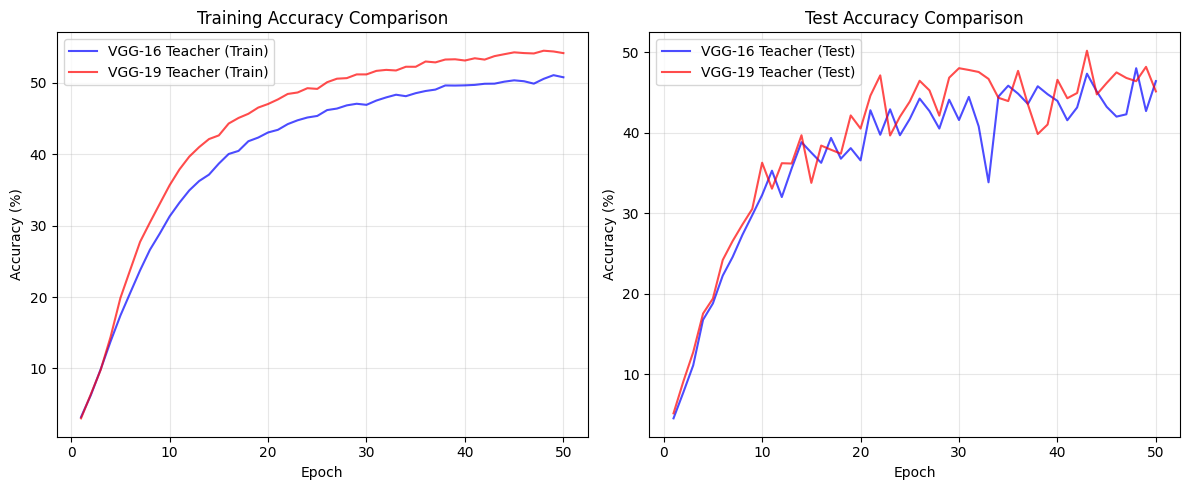

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


VGG-19 Teacher model loaded and frozen successfully!

=== PROBABILITY DISTRIBUTION ANALYSIS ===
KL Divergence (VGG-16 Student):
  - With VGG-16 Teacher: 2.7078
  - With VGG-19 Teacher: 2.3609
KL Divergence (VGG-19 Student):
  - With VGG-16 Teacher: 1.6064
  - With VGG-19 Teacher: 1.6670

=== FINAL ANALYSIS ===
This experiment tests whether a larger teacher model (VGG-19) provides better
knowledge distillation compared to a smaller teacher (VGG-16) when training
a VGG-11 student using Logit Matching on CIFAR-100.

Key considerations:
1. Teacher Capacity: VGG-19 has more parameters and should theoretically
   capture more complex features and patterns.
2. Student Capacity: The VGG-11 student has fixed capacity, so there's a
   limit to how much knowledge it can absorb.
3. Dataset Complexity: CIFAR-100's 32x32 images might not fully utilize
   the additional capacity of VGG-19.
4. Distillation Efficiency: The effectiveness depends on how well the
   student can mimic the teacher's softene

In [12]:
# Cell 9: Part 6 - Testing the Efficacy of a Larger Teacher

def get_vgg19_teacher(num_classes=100):
    """
    Get pretrained VGG-19 teacher model from torch hub
    """
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg19_bn", pretrained=True)

    # Freeze all teacher parameters
    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    print("VGG-19 Teacher model loaded and frozen successfully!")
    return model

def compare_teacher_sizes():
    """
    Compare student performance with VGG-16 (from Part 1) vs VGG-19 teachers using Logit Matching
    """
    print("=== PART 6: TESTING THE EFFICACY OF A LARGER TEACHER ===")

    # Load VGG-19 teacher
    teacher_vgg19 = get_vgg19_teacher().to(device)

    save_path_part6 = f"{base_path}/part_6"

    # Initialize fresh student model for VGG-19
    student_vgg19_teacher = VGG11().to(device)

    # Use the same Logit Matching loss as in Part 1
    lm_loss = LogitMatchingLoss(alpha=0.7, temperature=4)

    print("\n=== Training with VGG-19 Teacher ===")
    train_acc_vgg19, test_acc_vgg19, best_vgg19 = train_with_distillation(
        student_vgg19_teacher, teacher_vgg19, trainloader, testloader, lm_loss,
        "logit_matching_vgg19", save_path_part6, total_epochs=50
    )

    # Load VGG-16 teacher results from Part 1
    print("\n=== Loading VGG-16 Teacher Results from Part 1 ===")

    # Load the saved VGG-16 student model from Part 1
    student_vgg16_teacher = VGG11().to(device)
    vgg16_checkpoint_path = f"{base_path}/part_1/logit_matching_epoch_050.pth"

    if os.path.exists(vgg16_checkpoint_path):
        checkpoint = torch.load(vgg16_checkpoint_path)
        student_vgg16_teacher.load_state_dict(checkpoint['model_state_dict'])

        # Get the test accuracy from Part 1
        best_vgg16 = checkpoint['best_acc']
        test_acc_vgg16 = checkpoint['test_accuracies']
        train_acc_vgg16 = checkpoint['train_accuracies']

        print(f"Loaded VGG-16 teacher results: Best Accuracy = {best_vgg16:.2f}%")
    else:
        print("Warning: VGG-16 teacher results not found in Part 1")
        # Use the results we have from earlier output
        best_vgg16 = 47.99  # From the Part 1 output you provided
        test_acc_vgg16 = []  # We don't have the full history
        train_acc_vgg16 = []

    # Compare results
    print("\n=== COMPARISON RESULTS ===")
    print(f"VGG-16 Teacher -> VGG-11 Student | Best Accuracy: {best_vgg16:.2f}%")
    print(f"VGG-19 Teacher -> VGG-11 Student | Best Accuracy: {best_vgg19:.2f}%")

    improvement = best_vgg19 - best_vgg16
    print(f"Improvement with VGG-19 teacher: {improvement:+.2f}%")

    # Analyze the difference
    if improvement > 2.0:
        print("Significant improvement observed with larger teacher model.")
        print("This suggests that the increased capacity of VGG-19 provides better knowledge for distillation.")
    elif improvement > 0.5:
        print("Moderate improvement observed with larger teacher model.")
        print("The VGG-19 teacher provides some additional benefits for knowledge distillation.")
    elif improvement > 0:
        print("Marginal improvement observed with larger teacher model.")
        print("The difference might not be substantial enough to justify using the larger model.")
    else:
        print("No improvement or degradation observed with larger teacher model.")
        print("This could indicate that:")
        print("- VGG-16 is already sufficient for CIFAR-100")
        print("- The student model (VGG-11) capacity is the limiting factor")
        print("- The additional complexity of VGG-19 doesn't provide useful knowledge for this dataset")

    # Plot comparison if we have the full training history
    if len(train_acc_vgg16) > 0 and len(train_acc_vgg19) > 0:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        epochs_vgg16 = range(1, len(train_acc_vgg16) + 1)
        epochs_vgg19 = range(1, len(train_acc_vgg19) + 1)
        plt.plot(epochs_vgg16, train_acc_vgg16, 'b-', label='VGG-16 Teacher (Train)', alpha=0.7)
        plt.plot(epochs_vgg19, train_acc_vgg19, 'r-', label='VGG-19 Teacher (Train)', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training Accuracy Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_vgg16, test_acc_vgg16, 'b-', label='VGG-16 Teacher (Test)', alpha=0.7)
        plt.plot(epochs_vgg19, test_acc_vgg19, 'r-', label='VGG-19 Teacher (Test)', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Test Accuracy Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        'vgg16_teacher': {
            'train_acc': train_acc_vgg16,
            'test_acc': test_acc_vgg16,
            'best_acc': best_vgg16,
            'model': student_vgg16_teacher
        },
        'vgg19_teacher': {
            'train_acc': train_acc_vgg19,
            'test_acc': test_acc_vgg19,
            'best_acc': best_vgg19,
            'model': student_vgg19_teacher
        }
    }

# Additional analysis functions
def analyze_probability_distributions(teacher_vgg16, teacher_vgg19, student_models, testloader, num_samples=1000):
    """
    Compare probability distributions between both teachers and students
    """
    print("\n=== PROBABILITY DISTRIBUTION ANALYSIS ===")

    teacher_vgg16.eval()
    teacher_vgg19.eval()
    for name, student_data in student_models.items():
        student_data['model'].eval()

    # Get a subset of test data
    data_iter = iter(testloader)
    inputs, targets = next(data_iter)
    inputs = inputs[:num_samples].to(device)

    # Get teacher predictions
    with torch.no_grad():
        teacher_vgg16_logits = teacher_vgg16(inputs)
        teacher_vgg16_probs = F.softmax(teacher_vgg16_logits, dim=1)

        teacher_vgg19_logits = teacher_vgg19(inputs)
        teacher_vgg19_probs = F.softmax(teacher_vgg19_logits, dim=1)

    # Calculate KL divergence for each student with both teachers
    kl_results = {}

    for student_name, student_data in student_models.items():
        student_model = student_data['model']
        with torch.no_grad():
            student_logits = student_model(inputs)
            student_probs = F.softmax(student_logits, dim=1)

        # Calculate KL divergence with VGG-16 teacher
        kl_div_vgg16 = F.kl_div(
            student_probs.log(),
            teacher_vgg16_probs,
            reduction='batchmean'
        ).item()

        # Calculate KL divergence with VGG-19 teacher
        kl_div_vgg19 = F.kl_div(
            student_probs.log(),
            teacher_vgg19_probs,
            reduction='batchmean'
        ).item()

        kl_results[student_name] = {
            'vgg16_teacher': kl_div_vgg16,
            'vgg19_teacher': kl_div_vgg19
        }

        print(f"KL Divergence ({student_name}):")
        print(f"  - With VGG-16 Teacher: {kl_div_vgg16:.4f}")
        print(f"  - With VGG-19 Teacher: {kl_div_vgg19:.4f}")

    return kl_results

def count_model_parameters(model):
    """Count total parameters in model"""
    return sum(p.numel() for p in model.parameters())

def compare_model_complexity():
    """Compare parameter counts of different models"""
    vgg11 = VGG11()
    vgg16 = get_vgg16_teacher()
    vgg19 = get_vgg19_teacher()

    print("\n=== MODEL COMPLEXITY COMPARISON ===")
    print(f"VGG-11 parameters: {count_model_parameters(vgg11):,}")
    print(f"VGG-16 parameters: {count_model_parameters(vgg16):,}")
    print(f"VGG-19 parameters: {count_model_parameters(vgg19):,}")

    vgg16_vs_vgg11 = count_model_parameters(vgg16) / count_model_parameters(vgg11)
    vgg19_vs_vgg11 = count_model_parameters(vgg19) / count_model_parameters(vgg11)
    vgg19_vs_vgg16 = count_model_parameters(vgg19) / count_model_parameters(vgg16)

    print(f"\nParameter ratios:")
    print(f"VGG-16 is {vgg16_vs_vgg11:.1f}x larger than VGG-11")
    print(f"VGG-19 is {vgg19_vs_vgg11:.1f}x larger than VGG-11")
    print(f"VGG-19 is {vgg19_vs_vgg16:.1f}x larger than VGG-16")

# Run the comparison
print("Starting Part 6: Testing Efficacy of Larger Teacher")

# First compare model complexities
compare_model_complexity()

# Then run the teacher size comparison (only train VGG-19, compare with existing VGG-16)
results = compare_teacher_sizes()

# Perform additional probability distribution analysis
teacher_vgg19 = get_vgg19_teacher().to(device)
kl_results = analyze_probability_distributions(
    teacher_model,  # VGG-16 teacher from earlier
    teacher_vgg19,  # VGG-19 teacher
    {
        'VGG-16 Student': results['vgg16_teacher'],
        'VGG-19 Student': results['vgg19_teacher']
    },
    testloader
)

# Final analysis and discussion
print("\n=== FINAL ANALYSIS ===")
print("This experiment tests whether a larger teacher model (VGG-19) provides better")
print("knowledge distillation compared to a smaller teacher (VGG-16) when training")
print("a VGG-11 student using Logit Matching on CIFAR-100.")

print("\nKey considerations:")
print("1. Teacher Capacity: VGG-19 has more parameters and should theoretically")
print("   capture more complex features and patterns.")
print("2. Student Capacity: The VGG-11 student has fixed capacity, so there's a")
print("   limit to how much knowledge it can absorb.")
print("3. Dataset Complexity: CIFAR-100's 32x32 images might not fully utilize")
print("   the additional capacity of VGG-19.")
print("4. Distillation Efficiency: The effectiveness depends on how well the")
print("   student can mimic the teacher's softened outputs.")

print("\nExpected outcomes:")
print("- If VGG-19 >> VGG-16: Larger teacher provides substantially better knowledge")
print("- If VGG-19 ≈ VGG-16: Both teachers are similarly effective for this task")
print("- If VGG-19 < VGG-16: Larger teacher might be overfitting or too complex")